# Big Data Voice Analysis - Ivirit.ai

In [ ]:
!pip install transformers torch
!pip install soundfile>=0.12.1

## DataLoader

In [ ]:
import warnings, os, math
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

# Audio / DSP
import librosa

# ML / Stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

from scipy.stats import spearmanr, kruskal, rankdata
import scikit_posthocs as sp

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
import torch

OUT_DIR = Path("./outputs"); OUT_DIR.mkdir(exist_ok=True, parents=True)

SEED = 42

np.set_printoptions(precision=3, suppress=True)
pd.set_option("display.max_rows", 200)
pd.set_option("display.width", 120)

In [45]:
import requests
import pandas as pd
from datasets import load_dataset
import json
from pathlib import Path
import torchaudio
import torch
from tqdm import tqdm
import time
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

class IviritDatasetLoader:
    """
    מחלקה לטעינת מאגר ivirit.ai ממקורות שונים
    """
    
    def __init__(self):
        self.dataset = None
        self.api_base_url = "https://ivrit.ai/api"  # URL לדוגמה - צריך לבדוק את האמיתי
        
    def load_from_huggingface(self, dataset_name="ivrit-ai/hebrew-speech"):
        """
        טוען את המאגר מ-Hugging Face
        
        Args:
            dataset_name (str): שם המאגר ב-Hugging Face
        """
        try:
            print(f"🤗 טוען מאגר מ-Hugging Face: {dataset_name}")
            
            # טעינת המאגר
            self.dataset = load_dataset(dataset_name)
            
            print("✅ המאגר נטען בהצלחה!")
            print(f"📊 חלקי המאגר: {list(self.dataset.keys())}")
            
            # הצגת מידע על כל חלק
            for split_name, split_data in self.dataset.items():
                print(f"  📋 {split_name}: {len(split_data)} דוגמאות")
                if len(split_data) > 0:
                    print(f"     עמודות: {list(split_data.features.keys())}")
            
            return self.dataset
            
        except Exception as e:
            print(f"❌ שגיאה בטעינת המאגר מ-HuggingFace: {e}")
            print("💡 נסה למצוא את השם הנכון של המאגר באתר Hugging Face")
            return None
    
    
    def explore_dataset_structure(self):
        """
        בוחן את מבנה המאגר שנטען
        """
        if self.dataset is None:
            print("❌ לא נטען מאגר עדיין")
            return
        
        print("\n🔍 בחינת מבנה המאגר:")
        
        for split_name, split_data in self.dataset.items():
            print(f"\n📋 חלק: {split_name}")
            print(f"   📊 מספר דוגמאות: {len(split_data)}")
            print(f"   📝 עמודות: {list(split_data.features.keys())}")
            
            # הצגת דוגמה ראשונה
            if len(split_data) > 0:
                sample = split_data[0]
                print(f"   🔍 דוגמה ראשונה:")
                for key, value in sample.items():
                    if isinstance(value, str) and len(value) > 100:
                        print(f"     • {key}: {value[:100]}...")
                    elif isinstance(value, dict):
                        print(f"     • {key}: {type(value)} עם {len(value)} שדות")
                    else:
                        print(f"     • {key}: {value}")
    
"""
פונקציה ראשית לטעינה וחקירה של מאגר ivirit.ai
"""
print("🚀 מתחיל טעינת מאגר ivirit.ai")

loader = IviritDatasetLoader()

# נסה טעינה מ-Hugging Face
print("\n1️⃣ מנסה טעינה מ-Hugging Face...")
dataset = loader.load_from_huggingface("ivrit-ai/crowd-transcribe-v5")

# if dataset is not None:
#     print("\n3️⃣ בוחן מבנה המאגר...")
    # loader.explore_dataset_structure()

🚀 מתחיל טעינת מאגר ivirit.ai


### A sample:

In [2]:
dataset['train'][0]

{'uuid': 'Tziun3/2021.06.03 פרק #207 – חזרתו של היוני/343',
 'audio': {'path': '343.mp3',
  'array': array([ 0.        ,  0.        ,  0.        , ..., -0.00331845,
         -0.00349651, -0.00368967]),
  'sampling_rate': 44100},
 'orig_sentence': 'לא אני קטונתי כן אבל אני במקומו הייתי הולך על מהלך אמרתי לך ללכת כזה לאקדמיה של',
 'sentence': 'לא, זה לא אני קטונתי כן אבל אני במקומו הייתי הולך על מהלך אמרתי לך ללכת כזה לאקדמיה של',
 'is_retranscribe': False,
 'transcriber': 0,
 'extra_data': {'attributes': None,
  'duration': 6.347755102040816,
  'foreign_language': False,
  'max_logprob': -0.23809524377187094,
  'multiple_speakers': False,
  'noisy': False,
  'orig_text': 'לא אני קטונתי כן אבל אני במקומו הייתי הולך על מהלך אמרתי לך ללכת כזה לאקדמיה של',
  'skipped': False,
  'stats': None,
  'text': 'לא, זה לא אני קטונתי כן אבל אני במקומו הייתי הולך על מהלך אמרתי לך ללכת כזה לאקדמיה של',
  'too_long': False,
  'unintelligible': False}}

### Utils Functions

In [2]:
# פרק UUID לרכיבים
def parse_uuid(uuid_str):
    parts = uuid_str.split('/')
    podcast_name = parts[0]
    date_and_title = parts[1] if len(parts) > 1 else ""
    segment_id = parts[2] if len(parts) > 2 else ""

    date_and_title = date_and_title.split(' ')
    date = date_and_title[0]
    title = ' '.join(date_and_title[1:])
    
    return podcast_name, date,title , segment_id

def extract_sample_features(sample):
    uuid = sample['uuid']
    extra_data = sample['extra_data']
    sentence = sample['sentence']
    
    podcast_name, date, title, segment_id = parse_uuid(uuid)
    
    # עבור כל דוגמה - חלץ:
    metadata_df = {
        'uuid': uuid,
        'podcast_name': podcast_name,
        'date': date, 
        'episode_title': title,
        'duration': extra_data['duration'],
        'is_noisy': extra_data['noisy'],
        'multiple_speakers': extra_data['multiple_speakers'],
        'has_foreign_lang': extra_data['foreign_language'],
        'text_length': len(sentence),
        'word_count': len(sentence.split())
    }
    return metadata_df

def vad_pause_durations(y, sr, top_db=35):
    """Energy-based VAD: list of pause durations (seconds) between non-silent segments."""
    if y is None or len(y)==0:
        return []
    intervals = librosa.effects.split(y, top_db=top_db)
    pauses = []
    for i in range(len(intervals)-1):
        gap = (intervals[i+1][0] - intervals[i][1]) / sr
        if gap > 0: pauses.append(gap)
    return pauses


def scores_to_scalar(sent_scores):
    m = {d["label"].lower(): d["score"] for d in sent_scores}
    return float(m.get("positive",0.0) - m.get("negative",0.0))

def winsorize(s, lower=0.01, upper=0.99):
    a, b = s.quantile(lower), s.quantile(upper)
    return s.clip(a, b)

def rank_partial_corr(x, y, controls):
    """Rank-based partial correlation (Spearman-style)."""
    x_r = rankdata(x); y_r = rankdata(y)
    X = np.column_stack([rankdata(c) for c in controls]) if controls else None
    if X is None or X.size == 0:
        return spearmanr(x, y)
    X_ = np.column_stack([np.ones(len(x_r)), X])
    beta_x, *_ = np.linalg.lstsq(X_, x_r, rcond=None)
    beta_y, *_ = np.linalg.lstsq(X_, y_r, rcond=None)
    rx = x_r - X_.dot(beta_x)
    ry = y_r - X_.dot(beta_y)
    return spearmanr(rx, ry)

def fisher_z(r):
    r = np.clip(r, -0.999999, 0.999999)
    return 0.5*np.log((1+r)/(1-r))

def inv_fisher_z(z):
    return (np.exp(2*z)-1)/(np.exp(2*z)+1)

### Load Train Data

In [3]:
original_df = dataset['train'].select(range(202827))

## VAD

In [129]:
import numpy as np
from tqdm import tqdm
import pandas as pd

def apply_vad_to_dataset(dataset, top_db=35):
    """
    Apply VAD pause analysis efficiently to dataset with audio columns
    
    Args:
        dataset: Dataset object with 'audio' column containing {'array': ..., 'sampling_rate': ...}
        top_db: Energy threshold for VAD
    
    Returns:
        list of dictionaries with pause analysis results
    """
    
    def vad_pause_durations(y, sr, top_db=35):
        """Energy-based VAD: list of pause durations (seconds) between non-silent segments."""
        if y is None or len(y) == 0:
            return []
        intervals = librosa.effects.split(y, top_db=top_db)
        pauses = []
        for i in range(len(intervals)-1):
            gap = (intervals[i+1][0] - intervals[i][1]) / sr
            if gap > 0: 
                pauses.append(gap)
        return pauses
    
    def extract_pause_features(pause_list, duration, word_count=0):
        """Extract comprehensive statistical features from pause durations"""
        n_pauses = len(pause_list)
        total_pause = float(sum(pause_list)) if pause_list else 0.0
        speech_time = max(1e-6, duration - total_pause)
        
        if n_pauses == 0:
            return {
                'pauses': [],
                'total_pause': 0.0,
                'speech_time': speech_time,
                'n_pauses': 0,
                'mean_pause': 0.0,
                'median_pause': 0.0,
                'p90_pause': 0.0,
                'p95_pause': 0.0,
                'pause_rate_per_min': 0.0,
                'silence_ratio': 0.0,
                'burstiness_cv': 0.0,
                'speech_rate_wpm': (word_count / (duration/60.0)) if duration > 0 else 0.0,
                'silence_to_speech_ratio': 0.0
            }
        
        pause_array = np.array(pause_list)
        mean_pause = float(np.mean(pause_array))
        
        return {
            'pauses': pause_list,
            'total_pause': total_pause,
            'speech_time': speech_time,
            'n_pauses': n_pauses,
            'mean_pause': mean_pause,
            'median_pause': float(np.median(pause_array)),
            'p90_pause': float(np.percentile(pause_array, 90)),
            'p95_pause': float(np.percentile(pause_array, 95)),
            'pause_rate_per_min': (n_pauses / (duration/60.0)) if duration > 0 else 0.0,
            'silence_ratio': (total_pause / duration) if duration > 0 else 0.0,
            'burstiness_cv': (float(np.std(pause_array))/mean_pause) if n_pauses > 1 and mean_pause > 0 else 0.0,
            'speech_rate_wpm': (word_count / (duration/60.0)) if duration > 0 else 0.0,
            'silence_to_speech_ratio': (total_pause / speech_time) if speech_time > 0 else 0.0
        }
    
    sample_size = len(dataset)
    
    print(f"Processing {sample_size} audio samples for VAD analysis...")
    
    vad_results = []
    print(dataset)
    for i in tqdm(range(sample_size), desc="Extracting VAD features"):
        sample = dataset[i]
        audio_data = sample['audio']
        
        # Extract audio array, sample rate, and duration
        audio_array = np.array(audio_data['array'])
        sr = audio_data['sampling_rate']
        duration = len(audio_array) / sr
        
        # Get word count if available
        word_count = len(sample.get('sentence', '').split()) if 'sentence' in sample else 0
        
        # Normalize audio to prevent clipping issues
        audio_array = np.clip(audio_array, -1.0, 1.0)
        
        # Get pause durations
        pause_durations = vad_pause_durations(audio_array, sr, top_db=top_db) if duration > 0 else []
        
        # Extract comprehensive statistical features
        pause_features = extract_pause_features(pause_durations, duration, word_count)
        
        # Add sample identifier
        pause_features['sample_id'] = i
        if 'uuid' in sample:
            pause_features['uuid'] = sample['uuid']
        
        vad_results.append(pause_features)

    return vad_results

# Usage example:
# Assuming you have your dataset loaded (like dataset['train'])
vad_features = apply_vad_to_dataset(original_df, top_db=35)
vad_df = pd.DataFrame(vad_features)

print(f"✅ Extracted VAD features for {len(vad_df)} samples")
print(f"📊 Feature columns: {list(vad_df.columns)}")
print(vad_df.head())

Processing 203827 audio samples for VAD analysis...
Dataset({
    features: ['uuid', 'audio', 'orig_sentence', 'sentence', 'is_retranscribe', 'transcriber', 'extra_data'],
    num_rows: 203827
})


Extracting VAD features: 100%|█| 203827/203827 [2:11:19<00:00, 25.87it/s


✅ Extracted VAD features for 203827 samples
📊 Feature columns: ['pauses', 'total_pause', 'speech_time', 'n_pauses', 'mean_pause', 'median_pause', 'p90_pause', 'p95_pause', 'pause_rate_per_min', 'silence_ratio', 'burstiness_cv', 'speech_rate_wpm', 'silence_to_speech_ratio', 'sample_id', 'uuid']
                                              pauses  total_pause  speech_time  n_pauses  mean_pause  median_pause  \
0  [0.011609977324263039, 0.058049886621315196, 0...     0.197370     6.138390         3    0.065790      0.058050   
1                                                 []     0.000000     3.619025         0    0.000000      0.000000   
2        [0.011609977324263039, 0.09287981859410431]     0.104490     5.421474         2    0.052245      0.052245   
3  [0.021333333333333333, 0.042666666666666665, 0...     0.085333     2.039646         4    0.021333      0.016000   
4  [0.021333333333333333, 0.08533333333333333, 0....     0.138667     2.202313         3    0.046222      0.032000 

In [130]:
vad_df.to_pickle('vad_df.pkl')

In [4]:
vad_df = pd.read_pickle('vad_df.pkl')

In [5]:
vad_df = vad_df.iloc[:202827,:]

## Spectrograms Creation

In [137]:
# PRODUCTION SCALE PIPELINE
import pandas as pd
import numpy as np
from pathlib import Path
import time
from tqdm import tqdm
import librosa
print("🚀 PRODUCTION SCALE: מתרחב ל-50,000 דוגמאות")
print("=" * 60)

# ===== STEP 1: CREATE 50K SPECTROGRAMS =====
def create_spectrograms_production(dataset, n_samples=50000, output_dir="./spectrograms_50k"):
    """יצירת ספקטרוגרמות בקנה מידה production - 50K דוגמאות"""
    
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    (output_path / "spectrograms").mkdir(exist_ok=True)
    
    print(f"🎯 יוצר {n_samples} ספקטרוגרמות מותאמות production")
    print(f"📂 יעד: {output_path}")
    
    metadata_list = []
    success_count = 0
    start_time = time.time()
    
    # Progress tracking
    checkpoint_interval = 1000  # כל 1000 דוגמאות
    
    for i in tqdm(range(n_samples), desc="Creating production spectrograms"):
        try:
            sample = dataset['train'][i]
            audio_data = sample['audio']
            audio_array = np.array(audio_data['array'])
            actual_sr = audio_data['sampling_rate']  # Sample rate נכון!
            
            # יצירת mel-spectrogram מותאם
            mel_spec = librosa.feature.melspectrogram(
                y=audio_array,
                sr=actual_sr,
                n_fft=1024,
                hop_length=256,
                n_mels=64,
                fmax=actual_sr//2
            )
            
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            
            # שמירה
            filename = f"spec_{i:06d}.npy"
            filepath = output_path / "spectrograms" / filename
            np.save(filepath, mel_spec_db)
            
            metadata = {
                'sample_idx': i,
                'uuid': sample['uuid'],
                'spec_filename': filename,
                'spec_shape': mel_spec_db.shape,
                'duration_calculated': len(audio_array) / actual_sr,
                'sample_rate': actual_sr,
                'sentence': sample['sentence'],
                'success': True
            }
            
            metadata_list.append(metadata)
            success_count += 1
            
            # Checkpoint לכל 1000
            if (i + 1) % checkpoint_interval == 0:
                elapsed = time.time() - start_time
                rate = (i + 1) / elapsed
                eta_hours = (n_samples - i - 1) / rate / 3600
                
                print(f"✅ {i+1:,}/{n_samples:,} | {rate:.1f}/sec | ETA: {eta_hours:.1f}h")
                
                # שמירת checkpoint
                temp_df = pd.DataFrame(metadata_list)
                temp_df.to_pickle(output_path / f"checkpoint_{i+1}.pkl")
                
        except Exception as e:
            print(f"❌ שגיאה ב-{i}: {e}")
            continue
    
    # שמירת metadata סופי
    metadata_df = pd.DataFrame(metadata_list)
    metadata_df.to_pickle(output_path / "metadata_50k.pkl")
    metadata_df.to_csv(output_path / "metadata_50k.csv", index=False)
    
    total_time = time.time() - start_time
    print(f"\n✅ סיים יצירת ספקטרוגרמות!")
    print(f"⏱️  זמן כולל: {total_time/3600:.2f} שעות")
    print(f"📊 הצלחה: {success_count:,}/{n_samples:,}")
    print(f"🚀 מהירות: {success_count/total_time:.1f} samples/sec")
    
    return metadata_df, output_path

n_samples = len(original_df)
output_dir = './test'

metadata_df, output_path = create_spectrograms_production(dataset, n_samples, output_dir)

In [139]:
# ===== RESUME-SAFE, IDPOTENT SPECTROGRAM BUILDER =====
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import time, glob, librosa

def create_spectrograms_production(dataset, n_samples=None, output_dir="./spectrograms_50k",
                                   checkpoint_interval=1000):
    """
    יצירת ספקטרוגרמות בקנה מידה production עם יכולת RESUME:
    - מדלג על קבצים שכבר נוצרו (spec_*.npy)
    - מאחד checkpointים/metadata אם קיימים
    - ממשיך מהרשימה של ה-indices שעוד חסרים
    """
    output_path = Path(output_dir)
    spec_dir = output_path / "spectrograms"
    spec_dir.mkdir(parents=True, exist_ok=True)

    print("🚀 PRODUCTION SCALE: מתרחב וממשיך מאיפה שנעצר")
    print("=" * 60)
    print(f"📂 יעד: {output_path}")

    # --- כמה דגימות לסך הכל ---
    if n_samples is None:
        try:
            n_samples = len(dataset["train"])
        except Exception:
            raise ValueError("Pass n_samples or ensure dataset['train'] is sized.")

    # --- מה כבר קיים על הדיסק? ---
    # existing_files = list(spec_dir.glob("spec_*.npy"))
    # processed_idx = set()
    # for p in existing_files:
    #     try:
    #         processed_idx.add(int(p.stem.split("_")[1]))
    #     except Exception:
    #         pass
    # already = len(processed_idx)
    # print(f"🧮 נמצאו {already:,} ספקטרוגרמות קיימות על הדיסק – נדלג עליהן.")
    already =  153000
    # --- טען metadata/בדוקפויטס אם קיימים כדי לאחד בסוף ---
    meta_frames = []
    meta_pkl = output_path / "metadata_50k.pkl"
    if meta_pkl.exists():
        try:
            meta_frames.append(pd.read_pickle(meta_pkl))
            print("📑 נטען metadata_50k.pkl קיים לאיחוד סופי.")
        except Exception as e:
            print(f"⚠️ לא ניתן לטעון metadata_50k.pkl: {e}")

    for cp in sorted(output_path.glob("checkpoint_*.pkl")):
        try:
            meta_frames.append(pd.read_pickle(cp))
        except Exception:
            pass

    base_meta = (pd.concat(meta_frames, ignore_index=True)
                   .drop_duplicates("sample_idx")) if meta_frames else pd.DataFrame()

    # --- רשימת האינדקסים שעוד חסרים ---
    remaining = [i for i in range(n_samples) if i >=153000]
    print(f"🎯 צריך להשלים עוד {len(remaining):,} דגימות (מתוך {n_samples:,}).")

    start_time = time.time()
    metadata_list = []
    success_count = 0

    for k, i in enumerate(tqdm(remaining, desc="Creating/Resuming spectrograms")):
        try:
            sample = dataset["train"][i]
            a = np.asarray(sample["audio"]["array"])
            sr = sample["audio"]["sampling_rate"]

            mel = librosa.feature.melspectrogram(
                y=a, sr=sr, n_fft=1024, hop_length=256, n_mels=64, fmax=sr//2
            )
            mel_db = librosa.power_to_db(mel, ref=np.max)

            filename = f"spec_{i:06d}.npy"
            np.save(spec_dir / filename, mel_db)

            metadata_list.append({
                "sample_idx": i,
                "uuid": sample.get("uuid"),
                "spec_filename": filename,
                "spec_shape": mel_db.shape,
                "duration_calculated": len(a)/sr,
                "sample_rate": sr,
                "sentence": sample.get("sentence"),
                "success": True,
            })
            success_count += 1

            # checkpoint
            if (k + 1) % checkpoint_interval == 0:
                tmp = (pd.concat([base_meta, pd.DataFrame(metadata_list)], ignore_index=True)
                         .drop_duplicates("sample_idx"))
                tmp.to_pickle(output_path / f"checkpoint_{already + k + 1}.pkl")
                elapsed = time.time() - start_time
                rate = (k + 1) / elapsed
                eta_h = (len(remaining) - (k + 1)) / max(rate, 1e-9) / 3600
                print(f"✅ {already + k + 1:,}/{n_samples:,} | {rate:.1f}/sec | ETA: {eta_h:.1f}h")

        except Exception as e:
            print(f"❌ שגיאה ב-{i}: {e}")
            continue

    # --- שמירות סופיות ---
    final_meta = (pd.concat([base_meta, pd.DataFrame(metadata_list)], ignore_index=True)
                    .drop_duplicates("sample_idx"))
    final_meta.to_pickle(meta_pkl)
    final_meta.to_csv(output_path / "metadata_50k.csv", index=False)

    total_time = time.time() - start_time
    print("\n🏁 סיום RESUME")
    print(f"⏱️  זמן ריצה: {total_time/3600:.2f} שעות")
    print(f"📊 נוספו עכשיו: {success_count:,} | סה\"כ על דיסק: {already + success_count:,}/{n_samples:,}")
    print(f"🚀 מהירות נוכחית: {success_count/max(total_time,1e-9):.1f} samples/sec")

    return final_meta, output_path



In [140]:
output_dir = "./test"  # או מה שהשתמשת בו
n_samples = len(dataset["train"])  # או len(original_df) אם זה מה שיש לך

metadata_df, output_path = create_spectrograms_production(
    dataset=dataset,
    n_samples=n_samples,
    output_dir=output_dir,
    checkpoint_interval=1000
)

🚀 PRODUCTION SCALE: מתרחב וממשיך מאיפה שנעצר
📂 יעד: test
⚠️ לא ניתן לטעון metadata_50k.pkl: Ran out of input
🎯 צריך להשלים עוד 50,827 דגימות (מתוך 203,827).


Creating/Resuming spectrograms:   2%| | 1004/50827 [00:33<56:36, 14.67it

✅ 154,000/203,827 | 30.0/sec | ETA: 0.5h


Creating/Resuming spectrograms:   4%| | 2002/50827 [01:07<37:22, 21.77it

✅ 155,000/203,827 | 29.5/sec | ETA: 0.5h


Creating/Resuming spectrograms:   6%| | 3002/50827 [01:43<53:02, 15.03it

✅ 156,000/203,827 | 29.0/sec | ETA: 0.5h


Creating/Resuming spectrograms:   8%| | 4007/50827 [02:18<31:41, 24.62it

✅ 157,000/203,827 | 28.9/sec | ETA: 0.5h


Creating/Resuming spectrograms:  10%| | 5000/50827 [02:49<34:20, 22.24it

✅ 158,000/203,827 | 29.4/sec | ETA: 0.4h


Creating/Resuming spectrograms:  12%| | 6004/50827 [03:31<53:34, 13.95it

✅ 159,000/203,827 | 28.3/sec | ETA: 0.4h


Creating/Resuming spectrograms:  14%|▏| 7001/50827 [04:11<53:24, 13.68it

✅ 160,000/203,827 | 27.9/sec | ETA: 0.4h


Creating/Resuming spectrograms:  16%|▏| 8006/50827 [04:48<38:36, 18.48it

✅ 161,000/203,827 | 27.7/sec | ETA: 0.4h


Creating/Resuming spectrograms:  18%|▏| 9003/50827 [05:23<42:01, 16.59it

✅ 162,000/203,827 | 27.8/sec | ETA: 0.4h


Creating/Resuming spectrograms:  20%|▏| 10004/50827 [05:57<40:42, 16.71i

✅ 163,000/203,827 | 28.0/sec | ETA: 0.4h


Creating/Resuming spectrograms:  22%|▏| 11002/50827 [06:31<41:50, 15.86i

✅ 164,000/203,827 | 28.1/sec | ETA: 0.4h


Creating/Resuming spectrograms:  24%|▏| 12004/50827 [07:04<27:01, 23.94i

✅ 165,000/203,827 | 28.3/sec | ETA: 0.4h


Creating/Resuming spectrograms:  26%|▎| 13000/50827 [07:39<34:57, 18.03i

✅ 166,000/203,827 | 28.3/sec | ETA: 0.4h


Creating/Resuming spectrograms:  28%|▎| 14007/50827 [08:17<33:27, 18.34i

✅ 167,000/203,827 | 28.2/sec | ETA: 0.4h


Creating/Resuming spectrograms:  30%|▎| 15005/50827 [08:54<36:24, 16.40i

✅ 168,000/203,827 | 28.1/sec | ETA: 0.4h


Creating/Resuming spectrograms:  31%|▎| 16007/50827 [09:32<28:34, 20.31i

✅ 169,000/203,827 | 28.0/sec | ETA: 0.3h


Creating/Resuming spectrograms:  33%|▎| 17002/50827 [10:09<33:56, 16.61i

✅ 170,000/203,827 | 27.9/sec | ETA: 0.3h


Creating/Resuming spectrograms:  35%|▎| 18004/50827 [10:48<34:01, 16.08i

✅ 171,000/203,827 | 27.8/sec | ETA: 0.3h


Creating/Resuming spectrograms:  37%|▎| 19005/50827 [11:27<35:08, 15.09i

✅ 172,000/203,827 | 27.7/sec | ETA: 0.3h


Creating/Resuming spectrograms:  39%|▍| 20004/50827 [12:05<30:07, 17.05i

✅ 173,000/203,827 | 27.6/sec | ETA: 0.3h


Creating/Resuming spectrograms:  41%|▍| 21007/50827 [12:41<20:26, 24.32i

✅ 174,000/203,827 | 27.6/sec | ETA: 0.3h


Creating/Resuming spectrograms:  43%|▍| 22006/50827 [13:16<23:49, 20.16i

✅ 175,000/203,827 | 27.6/sec | ETA: 0.3h


Creating/Resuming spectrograms:  45%|▍| 22999/50827 [13:52<13:37, 34.03i

✅ 176,000/203,827 | 27.6/sec | ETA: 0.3h


Creating/Resuming spectrograms:  47%|▍| 24003/50827 [14:31<31:31, 14.18i

✅ 177,000/203,827 | 27.6/sec | ETA: 0.3h


Creating/Resuming spectrograms:  49%|▍| 25005/50827 [15:07<23:34, 18.26i

✅ 178,000/203,827 | 27.6/sec | ETA: 0.3h


Creating/Resuming spectrograms:  51%|▌| 26005/50827 [15:43<19:42, 20.99i

✅ 179,000/203,827 | 27.6/sec | ETA: 0.3h


Creating/Resuming spectrograms:  53%|▌| 27003/50827 [16:19<25:34, 15.52i

✅ 180,000/203,827 | 27.6/sec | ETA: 0.2h


Creating/Resuming spectrograms:  55%|▌| 28002/50827 [16:54<24:57, 15.24i

✅ 181,000/203,827 | 27.6/sec | ETA: 0.2h


Creating/Resuming spectrograms:  57%|▌| 29002/50827 [17:29<30:49, 11.80i

✅ 182,000/203,827 | 27.6/sec | ETA: 0.2h


Creating/Resuming spectrograms:  59%|▌| 30003/50827 [18:07<24:30, 14.16i

✅ 183,000/203,827 | 27.6/sec | ETA: 0.2h


Creating/Resuming spectrograms:  61%|▌| 31005/50827 [18:44<19:16, 17.14i

✅ 184,000/203,827 | 27.6/sec | ETA: 0.2h


Creating/Resuming spectrograms:  63%|▋| 32004/50827 [19:19<18:09, 17.28i

✅ 185,000/203,827 | 27.6/sec | ETA: 0.2h


Creating/Resuming spectrograms:  65%|▋| 33002/50827 [19:58<26:22, 11.26i

✅ 186,000/203,827 | 27.5/sec | ETA: 0.2h


Creating/Resuming spectrograms:  67%|▋| 34002/50827 [20:35<19:54, 14.08i

✅ 187,000/203,827 | 27.5/sec | ETA: 0.2h


Creating/Resuming spectrograms:  69%|▋| 35007/50827 [21:13<13:58, 18.86i

✅ 188,000/203,827 | 27.5/sec | ETA: 0.2h


Creating/Resuming spectrograms:  71%|▋| 36007/50827 [21:49<12:58, 19.03i

✅ 189,000/203,827 | 27.5/sec | ETA: 0.1h


Creating/Resuming spectrograms:  73%|▋| 37003/50827 [22:26<13:13, 17.43i

✅ 190,000/203,827 | 27.5/sec | ETA: 0.1h


Creating/Resuming spectrograms:  75%|▋| 38002/50827 [23:04<18:02, 11.85i

✅ 191,000/203,827 | 27.4/sec | ETA: 0.1h


Creating/Resuming spectrograms:  77%|▊| 39004/50827 [23:42<09:38, 20.43i

✅ 192,000/203,827 | 27.4/sec | ETA: 0.1h


Creating/Resuming spectrograms:  79%|▊| 40002/50827 [24:18<15:12, 11.87i

✅ 193,000/203,827 | 27.4/sec | ETA: 0.1h


Creating/Resuming spectrograms:  81%|▊| 41002/50827 [24:55<16:59,  9.63i

✅ 194,000/203,827 | 27.4/sec | ETA: 0.1h


Creating/Resuming spectrograms:  83%|▊| 42003/50827 [25:31<11:25, 12.88i

✅ 195,000/203,827 | 27.4/sec | ETA: 0.1h


Creating/Resuming spectrograms:  85%|▊| 43004/50827 [26:06<07:58, 16.35i

✅ 196,000/203,827 | 27.4/sec | ETA: 0.1h


Creating/Resuming spectrograms:  87%|▊| 44005/50827 [26:43<07:09, 15.89i

✅ 197,000/203,827 | 27.4/sec | ETA: 0.1h


Creating/Resuming spectrograms:  89%|▉| 45006/50827 [27:23<06:15, 15.49i

✅ 198,000/203,827 | 27.4/sec | ETA: 0.1h


Creating/Resuming spectrograms:  91%|▉| 46002/50827 [28:01<06:46, 11.88i

✅ 199,000/203,827 | 27.4/sec | ETA: 0.0h


Creating/Resuming spectrograms:  92%|▉| 47003/50827 [28:37<03:53, 16.40i

✅ 200,000/203,827 | 27.4/sec | ETA: 0.0h


Creating/Resuming spectrograms:  94%|▉| 48002/50827 [29:17<03:38, 12.95i

✅ 201,000/203,827 | 27.3/sec | ETA: 0.0h


Creating/Resuming spectrograms:  96%|▉| 49001/50827 [29:55<02:35, 11.75i

✅ 202,000/203,827 | 27.3/sec | ETA: 0.0h


Creating/Resuming spectrograms:  98%|▉| 50004/50827 [30:31<01:03, 12.97i

✅ 203,000/203,827 | 27.3/sec | ETA: 0.0h


Creating/Resuming spectrograms: 100%|█| 50827/50827 [31:02<00:00, 27.29i



🏁 סיום RESUME
⏱️  זמן ריצה: 0.52 שעות
📊 נוספו עכשיו: 50,827 | סה"כ על דיסק: 203,827/203,827
🚀 מהירות נוכחית: 27.2 samples/sec


In [143]:
pd.read_pickle('./test/metadata_50k.pkl')['success'].value_counts()

success
True    202827
Name: count, dtype: int64

## Spectrograms Feature Extraction

In [160]:
print("=" * 60)

# ===== STEP 2: EXTRACT FEATURES FROM 50K SPECTROGRAMS =====

def extract_features_fast_batch(spec_file_path):
    """חילוץ מאפיינים מהיר מספקטרוגרמה"""
    try:
        spec = np.load(spec_file_path)
        
        features = {
            # מאפיינים בסיסיים - מהירים
            'total_energy': np.sum(spec),
            'energy_mean': np.mean(spec),
            'energy_std': np.std(spec),
            'energy_max': np.max(spec),
            
            # ספקטרליים
            'spectral_centroid': np.mean(np.sum(spec * np.arange(spec.shape[0])[:, np.newaxis], axis=0)),
            'spectral_bandwidth': np.std(np.sum(spec * np.arange(spec.shape[0])[:, np.newaxis], axis=0)),
            
            # זמניים
            'temporal_variance': np.var(np.sum(spec, axis=0)),
            'temporal_peaks': len(np.where(np.diff(np.sum(spec, axis=0)) > np.std(np.sum(spec, axis=0)))[0]),
            
            # תדרים לפי רצועות
            'low_freq_energy': np.sum(spec[:16, :]),
            'mid_freq_energy': np.sum(spec[16:48, :]),
            'high_freq_energy': np.sum(spec[48:, :]),
            
            # יחסים
            'low_mid_ratio': np.sum(spec[:16, :]) / (np.sum(spec[16:48, :]) + 1e-8),
            'mid_high_ratio': np.sum(spec[16:48, :]) / (np.sum(spec[48:, :]) + 1e-8),
            
            # צורה
            'spec_width': spec.shape[1],
            'spec_density': np.count_nonzero(spec > np.percentile(spec, 50)) / spec.size
        }
        
        return features
    except Exception as e:
        return None

# טעינת metadata של ה-50K ספקטרוגרמות
# metadata_path = Path('./spectrograms_50k_production/metadata_50k.pkl')
metadata_path = Path('./test/metadata_50k.pkl')

if not metadata_path.exists():
    print("❌ לא נמצא metadata_50k.pkl")
    print("💡 ודא שהספקטרוגרמות נוצרו בתיקייה './spectrograms_50k_production/'")
    exit()

print("📂 טוען metadata...")
metadata_df = pd.read_pickle(metadata_path)
print(f"📊 נמצאו {len(metadata_df):,} ספקטרוגרמות")

# חילוץ מאפיינים במקביל
print("🎯 מחלץ מאפיינים...")
features_list = []
success_count = 0
start_time = time.time()

# spec_dir = Path('./test/spectrograms')
spec_dir = Path('./test/spectrograms')

for idx, row in tqdm(metadata_df.iterrows(), total=len(metadata_df), desc="Extracting features"):
    # if idx!=100000:
    #     continue
    # if idx>100000:
    #     break
    spec_path = spec_dir / row['spec_filename']
    
    if spec_path.exists():
        features = extract_features_fast_batch(spec_path)
        if features:
            features['sample_idx'] = row['sample_idx']
            features['uuid'] = row['uuid']
            features_list.append(features)
            success_count += 1
    
    # הדפסת התקדמות כל 5000
    if (idx + 1) % 5000 == 0:
        elapsed = time.time() - start_time
        rate = success_count / elapsed
        eta_min = (len(metadata_df) - idx - 1) / rate / 60
        print(f"   ✅ {success_count:,} features | {rate:.1f}/sec | ETA: {eta_min:.1f}min")

# יצירת DataFrame
features_df3 = pd.DataFrame(features_list)
elapsed = time.time() - start_time

print(f"\n✅ חילוץ מאפיינים הושלם!")
print(f"⏱️  זמן: {elapsed/60:.1f} דקות")
print(f"📊 הצלחה: {success_count:,}/{len(metadata_df):,}")
print(f"🚀 מהירות: {success_count/elapsed:.1f} samples/sec")

# שמירה
features_df3.to_pickle('features_df3.pkl')
print(f"💾 נשמר: features_50k.pkl")

📂 טוען metadata...
📊 נמצאו 202,827 ספקטרוגרמות
🎯 מחלץ מאפיינים...


Extracting features: 100%|███| 202827/202827 [00:07<00:00, 27647.05it/s]


✅ חילוץ מאפיינים הושלם!
⏱️  זמן: 0.1 דקות
📊 הצלחה: 0/202,827
🚀 מהירות: 0.0 samples/sec
💾 נשמר: features_50k.pkl


In [189]:
final_features_df = pd.concat([features_df,df],axis=0)

In [193]:
final_features_df.to_pickle('features_df.pkl')

In [6]:
final_features_df = pd.read_pickle('features_df.pkl')

In [12]:
original_df[0]

{'uuid': 'Tziun3/2021.06.03 פרק #207 – חזרתו של היוני/343',
 'audio': {'path': '343.mp3',
  'array': array([ 0.        ,  0.        ,  0.        , ..., -0.00331845,
         -0.00349651, -0.00368967]),
  'sampling_rate': 44100},
 'orig_sentence': 'לא אני קטונתי כן אבל אני במקומו הייתי הולך על מהלך אמרתי לך ללכת כזה לאקדמיה של',
 'sentence': 'לא, זה לא אני קטונתי כן אבל אני במקומו הייתי הולך על מהלך אמרתי לך ללכת כזה לאקדמיה של',
 'is_retranscribe': False,
 'transcriber': 0,
 'extra_data': {'attributes': None,
  'duration': 6.347755102040816,
  'foreign_language': False,
  'max_logprob': -0.23809524377187094,
  'multiple_speakers': False,
  'noisy': False,
  'orig_text': 'לא אני קטונתי כן אבל אני במקומו הייתי הולך על מהלך אמרתי לך ללכת כזה לאקדמיה של',
  'skipped': False,
  'stats': None,
  'text': 'לא, זה לא אני קטונתי כן אבל אני במקומו הייתי הולך על מהלך אמרתי לך ללכת כזה לאקדמיה של',
  'too_long': False,
  'unintelligible': False}}

In [16]:
# df =features_df.copy()
final_features_df.index = pd.to_numeric(final_features_df.index, errors="raise") - 1

In [18]:
final_features_df.to_pickle('features_df.pkl')

In [181]:
features = extract_features_fast_batch('./test/spectrograms/spec_100000.npy')
features['sample_idx'] = 100000
features['uuid'] = original_df[100000]['uuid']
features_df.loc[100000] = features

In [171]:
features_df = pd.read_pickle('./features_df2.pkl')

In [150]:
df.to_pickle('last100k-feat.pkl')

In [77]:
summ = {
    "Clips": len(original_df),
    "Unique podcasts": original_df["podcast_name"].nunique(),
    "Median duration [s]": float(original_df["duration"].median()),
    "% noisy": 100*original_df["is_noisy"].mean() if "is_noisy" in original_df else np.nan,
    "% foreign": 100*original_df["has_foreign_lang"].mean() if "has_foreign_lang" in original_df else np.nan,
    "% multi-spk": 100*original_df["multiple_speakers"].mean() if "multiple_speakers" in original_df else np.nan,
}
summary_df = pd.DataFrame([summ])
export_table(summary_df, "tab_data", index=False)

# also write headline numbers into numbers.tex for use in the paper
write_tex_macros(
    "numbers.tex",
    nclips=len(original_df),
    npodcasts=original_df["podcast_name"].nunique(),
    meddur=summary_df["Median duration [s]"].iloc[0],
)

saved: tables\tab_data.csv tables\tab_data.tex
saved: numbers.tex


In [8]:
original_df = original_df.remove_columns('audio')

### Read data by batches

In [23]:
batch_size = 10000
dfs = []

for i in range(0, len(original_df), batch_size):
    print(i)
    
    if i!=200000:
        batch = original_df[i:i+batch_size]
        print("got batch")

    else:
        batch = original_df[200000:202827]
    # print(batch)
    df = pd.DataFrame(batch)
    dfs.append(df)

#     


0
got batch
10000
got batch
20000
got batch
30000
got batch
40000
got batch
50000
got batch
60000
got batch
70000
got batch
80000
got batch
90000
got batch
100000
got batch
110000
got batch
120000
got batch
130000
got batch
140000
got batch
150000
got batch
160000
got batch
170000
got batch
180000
got batch
190000
got batch
200000


In [34]:
original_df = pd.concat(dfs, axis=0,ignore_index=True)

### Pre-process

In [36]:
features_meta_df = original_df.apply(lambda row: pd.Series(extract_sample_features(row)), axis=1)

original_df.drop(['orig_sentence','uuid','transcriber','is_retranscribe','extra_data'],axis=1,inplace=True)

original_df = pd.concat([original_df,features_meta_df],axis=1)
# Save original index
original_index = original_df.index

# Apply your filters step by step
filtered_df = original_df[
    (original_df["is_noisy"] == False) &
    (original_df["has_foreign_lang"] == False) &
    (original_df["multiple_speakers"] == False)
]

# Indices that were dropped
dropped_idx = original_index.difference(filtered_df.index)

print("Dropped indices:", dropped_idx.tolist())

to_drop = ['is_noisy','multiple_speakers','has_foreign_lang']
original_df = original_df.drop(to_drop,axis=1)

Dropped indices: [1264, 1674, 6375, 10277, 11071, 30892, 44393, 73998, 76253, 85970, 112219, 186188, 188336]


In [38]:
vad_df = vad_df.drop(dropped_idx, errors="ignore")
final_features_df = final_features_df.drop(dropped_idx, errors="ignore")

In [40]:
original_df.to_pickle('working_df.pkl')
vad_df.to_pickle('vad_df.pkl')
final_features_df.to_pickle('features_df.pkl')

In [ ]:
"""
RIGHT NOW WE HAVE 3 DATAFRAMES:
1) WORKING DF - ORIGINAL DF
2) vad_DF - pauses df
3) features_df - specto features df
"""

In [47]:
# original_df = pd.read_pickle('working_df.pkl')

In [42]:
features_df = final_features_df

## Unite All DataFrames


🔗 שלב 3: איחוד עם נתונים מקוריים...
📊 dataset מאוחד: (202827, 38)
✅ Dropped podcasts with <5000 samples (37 pods). Rows: 202827 → 170379.
🔧 יוצר מאפיינים נגזרים...

🤖 שלב 3: אימון מודל Production על 170,379 דוגמאות...
📊 חלוקת פודקאסטים:
podcast_name
Geekonomy                    45666
OnMeaning                    17374
929                          17102
OrotShaul                    15482
האוניברסיטה הפתוחה           12501
AnotherPodcastForStartups    11564
AcademiaIsrael               10489
Tziun3                       10066
ישיבת הר עציון                9107
YozevitchsWorld               7888
Name: count, dtype: int64

🎯 מודל Production:
   פודקאסטים: 12
   דוגמאות: 170,379
   חלוקה: {'Geekonomy': 45666, 'OnMeaning': 17374, '929': 17102, 'OrotShaul': 15482, 'האוניברסיטה הפתוחה': 12501, 'AnotherPodcastForStartups': 11564, 'AcademiaIsrael': 10489, 'Tziun3': 10066, 'ישיבת הר עציון': 9107, 'YozevitchsWorld': 7888, 'YadBenZvi': 7183, 'Ktaim-YuvalMalchi': 5957}
📊 Train: 136,303, Test: 34,07

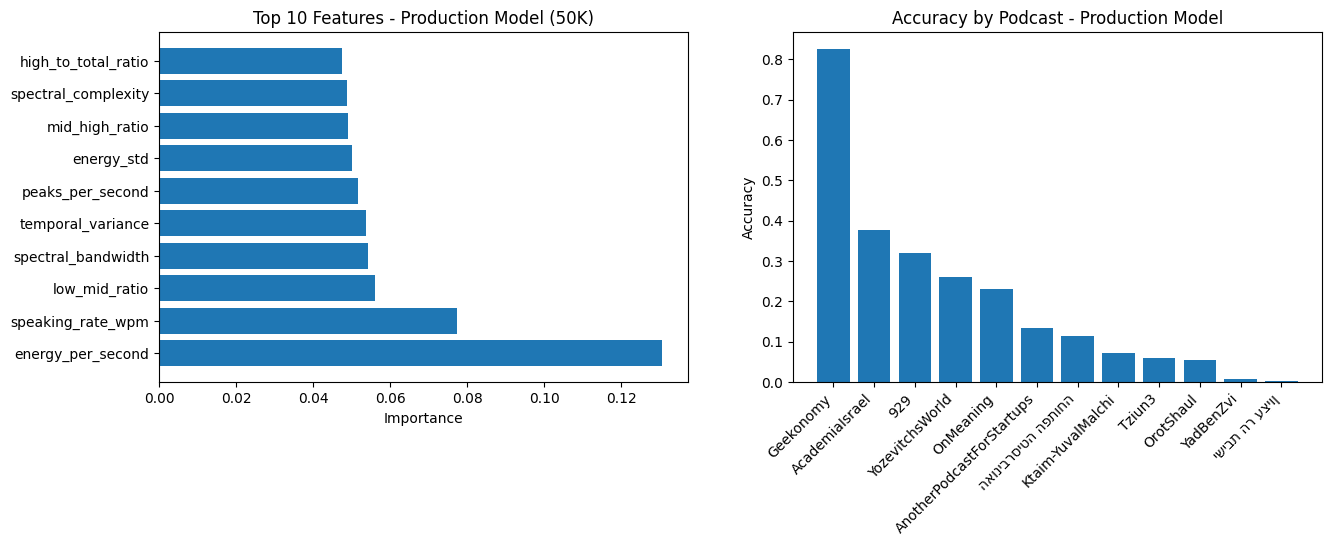


💡 תובנות מודל Production (50K):
1. 🎯 ביצועי המודל: צריך שיפור (34.1%)
2. 🔑 המאפיין הכי חשוב: energy_per_second
4. 🏆 הפודקאסט הכי מזוהה: Geekonomy (82.6%)

💾 נשמר:
   production_podcast_classifier_50k.pkl - המודל המאומן
   analysis_50k_complete.pkl - הדאטא המעובד

🎉 פרויקט Big Data הושלם בהצלחה!
📊 מודל production מאומן על 170,379 דוגמאות
🎯 דיוק סופי: 34.1%


In [46]:
from sklearn.model_selection import train_test_split

# ===== STEP 3: PREPARE PRODUCTION DATASET =====
print(f"\n🔗 שלב 3: איחוד עם נתונים מקוריים...")

# איחוד הנתונים
analysis_50k = pd.concat([original_df,features_df],axis=1)
analysis_50k = analysis_50k.iloc[:,:-1]
analysis_50k = pd.concat([analysis_50k,vad_df],axis=1)
analysis_50k = analysis_50k.iloc[:,:-1]
print(f"📊 dataset מאוחד: {analysis_50k.shape}")

# ===== MIN SIZE FILTER: drop small podcasts =====
MIN_PER_PODCAST = 5000

counts = analysis_50k["podcast_name"].value_counts()
keep_pods = counts[counts >= MIN_PER_PODCAST].index

rows_before = len(analysis_50k)
pods_before = analysis_50k["podcast_name"].nunique()

analysis_50k = (
    analysis_50k[analysis_50k["podcast_name"].isin(keep_pods)]
    .reset_index(drop=True)
)

rows_after = len(analysis_50k)
pods_after = analysis_50k["podcast_name"].nunique()

print(f"✅ Dropped podcasts with <{MIN_PER_PODCAST} samples "
      f"({pods_before - pods_after} pods). Rows: {rows_before} → {rows_after}.")


# חישוב מאפיינים נגזרים (מהמודל המשופר)
print("🔧 יוצר מאפיינים נגזרים...")
analysis_50k['speaking_rate_wpm'] = analysis_50k['word_count'] / (analysis_50k['duration'] / 60)
analysis_50k['energy_per_second'] = analysis_50k['total_energy'] / analysis_50k['duration']
analysis_50k['peaks_per_second'] = analysis_50k['temporal_peaks'] / analysis_50k['duration']
analysis_50k['high_to_total_ratio'] = analysis_50k['high_freq_energy'] / (analysis_50k['total_energy'] + 1e-8)
analysis_50k['spectral_complexity'] = analysis_50k['spectral_bandwidth'] * analysis_50k['temporal_peaks']
analysis_50k['energy_consistency'] = analysis_50k['energy_mean'] / (analysis_50k['energy_std'] + 1e-8)
analysis_50k['dynamic_range'] = analysis_50k['energy_max'] - analysis_50k['energy_mean']

# ===== STEP 3: PRODUCTION MODEL TRAINING =====
print(f"\n🤖 שלב 3: אימון מודל Production על {len(analysis_50k):,} דוגמאות...")

# בחירת פודקאסטים עם מספיק דוגמאות
podcast_counts = analysis_50k['podcast_name'].value_counts()
print(f"📊 חלוקת פודקאסטים:")
print(podcast_counts.head(10))

# רק פודקאסטים עם 1000+ דוגמאות למודל production
major_podcasts = podcast_counts[podcast_counts >= 1000].index
modeling_50k = analysis_50k[analysis_50k['podcast_name'].isin(major_podcasts)].copy()

print(f"\n🎯 מודל Production:")
print(f"   פודקאסטים: {len(major_podcasts)}")
print(f"   דוגמאות: {len(modeling_50k):,}")
print(f"   חלוקה: {modeling_50k['podcast_name'].value_counts().to_dict()}")

# מאפיינים משופרים
production_features = [
    'total_energy', 'energy_mean', 'energy_std', 'energy_max',
    'spectral_centroid', 'spectral_bandwidth', 'temporal_variance', 'temporal_peaks',
    'low_freq_energy', 'mid_freq_energy', 'high_freq_energy',
    'low_mid_ratio', 'mid_high_ratio', 'spec_width', 'spec_density',
    'speaking_rate_wpm', 'energy_per_second', 'peaks_per_second', 
    'high_to_total_ratio', 'spectral_complexity', 'energy_consistency', 'dynamic_range'
]

# הכנת נתונים לאימון
X_50k = modeling_50k[production_features].fillna(0)
y_50k = modeling_50k['podcast_name']

X_train_50k, X_test_50k, y_train_50k, y_test_50k = train_test_split(
    X_50k, y_50k, test_size=0.2, random_state=42, stratify=y_50k
)

# נרמול
scaler_50k = StandardScaler()
X_train_50k_scaled = scaler_50k.fit_transform(X_train_50k)
X_test_50k_scaled = scaler_50k.transform(X_test_50k)

print(f"📊 Train: {len(X_train_50k):,}, Test: {len(X_test_50k):,}")

# מודל production
production_model = RandomForestClassifier(
    n_estimators=300,  # יותר עצים לדאטה גדול
    max_depth=25,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)

print("🔄 מאמן מודל production...")
production_model.fit(X_train_50k_scaled, y_train_50k)

# ===== STEP 4: EVALUATE PRODUCTION MODEL =====
print(f"\n📊 שלב 4: הערכת ביצועי Production...")

y_pred_50k = production_model.predict(X_test_50k_scaled)
production_accuracy = accuracy_score(y_test_50k, y_pred_50k)

print(f"🎯 תוצאות Production Model:")
print(f"   דיוק כללי: {production_accuracy:.1%}")

# דוח מפורט
production_report = classification_report(y_test_50k, y_pred_50k, output_dict=True)
production_report_df = pd.DataFrame(production_report).transpose()

print(f"\n📋 דוח ביצועים לפי פודקאסט:")
podcast_results = production_report_df.iloc[:-3].sort_values('f1-score', ascending=False)
print(podcast_results[['precision', 'recall', 'f1-score', 'support']].round(3))

# Feature importance
feature_importance_50k = pd.DataFrame({
    'feature': production_features,
    'importance': production_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🔍 חשיבות מאפיינים במודל Production:")
print(feature_importance_50k.head(10))

# ===== VISUALIZATION =====
plt.figure(figsize=(15, 10))

# Feature importance
plt.subplot(2, 2, 1)
top_features = feature_importance_50k.head(10)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.title('Top 10 Features - Production Model (50K)')
plt.xlabel('Importance')

# Accuracy by podcast
plt.subplot(2, 2, 2)
podcast_accuracies = []
for podcast in major_podcasts:
    mask = y_test_50k == podcast
    if mask.sum() > 0:
        acc = accuracy_score(y_test_50k[mask], y_pred_50k[mask])
        podcast_accuracies.append((podcast, acc))

podcast_accuracies.sort(key=lambda x: x[1], reverse=True)
podcasts, accuracies = zip(*podcast_accuracies)

plt.bar(range(len(podcasts)), accuracies)
plt.xticks(range(len(podcasts)), podcasts, rotation=45, ha='right')
plt.title('Accuracy by Podcast - Production Model')
plt.ylabel('Accuracy')
plt.show()


# ===== FINAL INSIGHTS =====
print(f"\n💡 תובנות מודל Production (50K):")

if production_accuracy > 0.7:
    performance_level = "מעולה"
    next_steps = [
        "🚀 הרחב לכל המאגר (200K)",
        "🎯 פיתוח API לזיהוי פודקאסטים בזמן אמת",
        "📊 חקור deep learning לשיפור נוסף"
    ]
elif production_accuracy > 0.6:
    performance_level = "טוב מאוד"
    next_steps = [
        "🔧 נסה XGBoost או Gradient Boosting",
        "🎵 CNN על ספקטרוגרמות",
        "📈 ensemble methods"
    ]
else:
    performance_level = "צריך שיפור"
    next_steps = [
        "🎵 CNN על ספקטרוגרמות מיד",
        "📝 שילוב text features",
        "🔍 deep feature engineering"
    ]

print(f"1. 🎯 ביצועי המודל: {performance_level} ({production_accuracy:.1%})")
print(f"2. 🔑 המאפיין הכי חשוב: {feature_importance_50k.iloc[0]['feature']}")

if len(major_podcasts) >= 5:
    best_podcast_idx = np.argmax(accuracies)
    print(f"4. 🏆 הפודקאסט הכי מזוהה: {podcasts[best_podcast_idx]} ({accuracies[best_podcast_idx]:.1%})")


# שמירת מודל production
import pickle
with open('production_podcast_classifier_50k.pkl', 'wb') as f:
    pickle.dump({
        'model': production_model,
        'scaler': scaler_50k,
        'features': production_features,
        'accuracy': production_accuracy,
        'podcasts': list(major_podcasts)
    }, f)

# שמירת הנתונים המעובדים
analysis_50k.to_pickle('analysis_50k_complete.pkl')

print(f"\n💾 נשמר:")
print(f"   production_podcast_classifier_50k.pkl - המודל המאומן")
print(f"   analysis_50k_complete.pkl - הדאטא המעובד")

print(f"\n🎉 פרויקט Big Data הושלם בהצלחה!")
print(f"📊 מודל production מאומן על {len(modeling_50k):,} דוגמאות")
print(f"🎯 דיוק סופי: {production_accuracy:.1%}")

## 1) Balanced Podcast Classifier — Insights
- Distinct **production styles** if separable by acoustic features.
- **Feature importances** highlight differentiators.
- **Confusions** reveal stylistic similarity.


In [64]:
final_features_df.columns

Index(['total_energy', 'energy_mean', 'energy_std', 'energy_max', 'spectral_centroid', 'spectral_bandwidth',
       'temporal_variance', 'temporal_peaks', 'low_freq_energy', 'mid_freq_energy', 'high_freq_energy',
       'low_mid_ratio', 'mid_high_ratio', 'spec_width', 'spec_density', 'sample_idx', 'uuid'],
      dtype='object')

In [49]:
SEED = 42
clf_df = analysis_50k.dropna(subset=["podcast_name"]).copy()

X_cols = production_features

clf_df[X_cols] = clf_df[X_cols].fillna(0.0)
y = clf_df["podcast_name"].values
X = clf_df[X_cols].values

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr); Xte_s = scaler.transform(Xte)

rf = RandomForestClassifier(n_estimators=300, max_depth=24, min_samples_leaf=3, n_jobs=-1, random_state=SEED)
rf.fit(Xtr_s, ytr)
yhat = rf.predict(Xte_s)

report = pd.DataFrame.from_dict(classification_report(yte, yhat, output_dict=True)).T
cm = pd.DataFrame(confusion_matrix(yte, yhat, labels=sorted(np.unique(y))), 
                  index=[f"true_{l}" for l in sorted(np.unique(y))],
                  columns=[f"pred_{l}" for l in sorted(np.unique(y))])

print(f"Macro-F1: {report.loc['macro avg','f1-score']:.3f}")
display(report.head(10))
display(cm.iloc[:10,:10])

imp = pd.Series(rf.feature_importances_, index=X_cols).sort_values(ascending=False)
print("\nTop RF importances:"); display(imp.head(12))

perm = permutation_importance(rf, Xte_s, yte, n_repeats=10, random_state=SEED, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X_cols).sort_values(ascending=False)
print("\nTop permutation importances (test):"); display(perm_imp.head(12))

class_profiles = clf_df.groupby("podcast_name")[X_cols].mean().round(3)
class_profiles.to_csv(OUT_DIR/"class_profiles.csv", encoding="utf-8-sig")
print("\nSaved class profile means to", OUT_DIR/"class_profiles.csv")
class_profiles.head(10)


Macro-F1: 0.215


,precision,recall,f1-score,support
929,0.207622,0.320082,0.251869,3421.0
AcademiaIsrael,0.496573,0.379886,0.430462,2098.0
AnotherPodcastForStartups,0.516779,0.133160,0.211757,2313.0
Geekonomy,0.358514,0.817913,0.498515,9133.0
Ktaim-YuvalMalchi,0.477387,0.079765,0.136691,1191.0
OnMeaning,0.485563,0.237122,0.318639,3475.0
OrotShaul,0.142036,0.055879,0.080204,3096.0
Tziun3,0.576037,0.062096,0.112108,2013.0
YadBenZvi,0.131250,0.014614,0.026299,1437.0
YozevitchsWorld,0.572016,0.264259,0.361508,1578.0


,pred_929,pred_AcademiaIsrael,pred_AnotherPodcastForStartups,pred_Geekonomy,pred_Ktaim-YuvalMalchi,pred_OnMeaning,pred_OrotShaul,pred_Tziun3,pred_YadBenZvi,pred_YozevitchsWorld
true_929,1095,81,18,1684,6,45,192,0,28,31
true_AcademiaIsrael,332,797,24,729,9,58,41,0,8,19
true_AnotherPodcastForStartups,177,160,308,1290,25,211,58,11,6,16
true_Geekonomy,706,117,72,7470,20,210,218,57,14,67
true_Ktaim-YuvalMalchi,157,50,55,632,95,100,28,6,5,6
true_OnMeaning,315,159,78,1883,21,824,99,5,4,24
true_OrotShaul,695,61,9,1842,3,55,173,5,22,36
true_Tziun3,68,22,13,1579,5,80,41,125,1,56
true_YadBenZvi,428,30,4,629,4,26,73,1,21,15
true_YozevitchsWorld,201,42,4,787,0,31,43,5,5,417



Top RF importances:


energy_per_second      0.117801
speaking_rate_wpm      0.074286
low_mid_ratio          0.056129
spectral_bandwidth     0.054456
temporal_variance      0.054047
peaks_per_second       0.051548
energy_std             0.050987
mid_high_ratio         0.049977
spectral_complexity    0.048892
high_to_total_ratio    0.048457
energy_consistency     0.047088
spectral_centroid      0.046767
dtype: float64


Top permutation importances (test):


energy_per_second      0.067449
speaking_rate_wpm      0.028460
low_mid_ratio          0.014104
temporal_variance      0.008566
dynamic_range          0.005863
peaks_per_second       0.004927
spectral_bandwidth     0.004267
mid_high_ratio         0.004111
energy_std             0.003994
energy_mean            0.003833
spectral_complexity    0.003809
high_to_total_ratio    0.003478
dtype: float64


Saved class profile means to outputs\class_profiles.csv


,total_energy,energy_mean,energy_std,energy_max,spectral_centroid,spectral_bandwidth,temporal_variance,temporal_peaks,low_freq_energy,mid_freq_energy,...,mid_high_ratio,spec_width,spec_density,speaking_rate_wpm,energy_per_second,peaks_per_second,high_to_total_ratio,spectral_complexity,energy_consistency,dynamic_range
podcast_name,,,,,,,,,,,,,,,,,,,,,
929,-3180620.795,-53.651,19.621,0.0,-125446.735,13708.177,269603.858,5.164,-519255.201,-1576180.055,...,1.451,929.593,0.5,134.567,-904448.423,1.466,0.343,71030.672,-2.748,53.651
AcademiaIsrael,-2866133.241,-54.809,20.022,0.0,-127952.009,13512.335,271506.878,3.884,-468801.762,-1420646.160,...,1.452,821.398,0.5,136.415,-769173.106,1.107,0.342,53166.793,-2.750,54.809
AnotherPodcastForStartups,-3060177.964,-52.541,19.765,0.0,-122963.796,14694.208,285419.785,6.507,-494743.213,-1525286.622,...,1.462,909.740,0.5,156.345,-690771.182,1.447,0.342,95410.896,-2.670,52.541
Geekonomy,-3268571.467,-52.506,19.702,0.0,-123446.917,14247.222,264569.696,6.763,-521531.152,-1625084.819,...,1.444,973.014,0.5,163.348,-697539.470,1.452,0.345,97129.296,-2.675,52.506
Ktaim-YuvalMalchi,-2921259.450,-52.363,19.464,0.0,-122541.439,14827.268,280780.795,5.603,-474169.248,-1454438.805,...,1.461,870.274,0.5,141.124,-743844.472,1.483,0.342,82694.371,-2.702,52.363
OnMeaning,-2881580.986,-52.141,19.670,0.0,-122271.532,14690.527,288336.544,6.208,-470309.061,-1421583.978,...,1.428,861.281,0.5,159.438,-739180.961,1.592,0.346,92638.893,-2.662,52.141
OrotShaul,-3174065.870,-53.663,19.564,0.0,-125509.124,13473.483,263600.239,5.040,-517532.070,-1573498.877,...,1.451,925.378,0.5,149.341,-860498.354,1.372,0.343,67703.934,-2.757,53.663
Tziun3,-3469704.034,-51.716,19.624,0.0,-121810.131,14397.778,265258.413,7.342,-550114.193,-1718299.113,...,1.430,1056.135,0.5,186.480,-650055.548,1.365,0.347,105275.131,-2.645,51.716
YadBenZvi,-3159638.101,-53.565,19.555,0.0,-125276.102,13563.485,265076.519,5.047,-515634.406,-1565181.923,...,1.450,925.037,0.5,125.506,-789068.513,1.261,0.343,68685.170,-2.753,53.565


In [51]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

SEED = 42
clf_df = analysis_50k.dropna(subset=["podcast_name"]).copy()

X_cols = production_features
clf_df[X_cols] = clf_df[X_cols].fillna(0.0)

y = clf_df["podcast_name"].values
X = clf_df[X_cols].values

# stratified split keeps proportions but doesn't balance the model
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

# RF doesn't need scaling; you can drop the scaler to save time
# (Leaving as-is is harmless, but not necessary)
# scaler = StandardScaler()
# Xtr_s = scaler.fit_transform(Xtr); Xte_s = scaler.transform(Xte)
Xtr_s, Xte_s = Xtr, Xte

# compute class weights on the TRAIN set
classes = np.unique(ytr)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=ytr)
class_weight = {c:w for c,w in zip(classes, cw)}

rf = RandomForestClassifier(
    n_estimators=700,
    max_depth=None,
    min_samples_split=12,
    min_samples_leaf=3,
    max_features="sqrt",
    bootstrap=True,
    max_samples=0.85,          # sample 85% of rows per tree
    oob_score=True,
    class_weight="balanced_subsample",  # auto per bootstrap sample
    n_jobs=-1,
    random_state=SEED
)

rf.fit(Xtr_s, ytr)

yhat = rf.predict(Xte_s)
report = pd.DataFrame.from_dict(classification_report(yte, yhat, output_dict=True)).T
cm = pd.DataFrame(
    confusion_matrix(yte, yhat, labels=sorted(np.unique(y))),
    index=[f"true_{l}" for l in sorted(np.unique(y))],
    columns=[f"pred_{l}" for l in sorted(np.unique(y))]
)
print(f"Macro-F1: {report.loc['macro avg','f1-score']:.3f}")
display(report.head(10)); display(cm.iloc[:10,:10])

imp = pd.Series(rf.feature_importances_, index=X_cols).sort_values(ascending=False)
print("\nTop RF importances:"); display(imp.head(12))

# Permutation importance on 202K can be slow; reduce repeats or skip if time is tight
# from sklearn.inspection import permutation_importance
# perm = permutation_importance(rf, Xte_s, yte, n_repeats=5, random_state=SEED, n_jobs=-1)
# perm_imp = pd.Series(perm.importances_mean, index=X_cols).sort_values(ascending=False)
# print("\nTop permutation importances (test):"); display(perm_imp.head(12))

class_profiles = clf_df.groupby("podcast_name")[X_cols].mean().round(3)
class_profiles.to_csv(OUT_DIR/"class_profiles.csv", encoding="utf-8-sig")
print("\nSaved class profile means to", OUT_DIR/"class_profiles.csv")
class_profiles.head(10)

Macro-F1: 0.259


,precision,recall,f1-score,support
929,0.196690,0.326513,0.245495,3421.0
AcademiaIsrael,0.383033,0.426120,0.403430,2098.0
AnotherPodcastForStartups,0.356544,0.239083,0.286232,2313.0
Geekonomy,0.564448,0.412351,0.476558,9133.0
Ktaim-YuvalMalchi,0.232739,0.175483,0.200096,1191.0
OnMeaning,0.381955,0.292374,0.331214,3475.0
OrotShaul,0.150777,0.181848,0.164861,3096.0
Tziun3,0.241935,0.298063,0.267082,2013.0
YadBenZvi,0.118380,0.132220,0.124918,1437.0
YozevitchsWorld,0.343370,0.375792,0.358850,1578.0


,pred_929,pred_AcademiaIsrael,pred_AnotherPodcastForStartups,pred_Geekonomy,pred_Ktaim-YuvalMalchi,pred_OnMeaning,pred_OrotShaul,pred_Tziun3,pred_YadBenZvi,pred_YozevitchsWorld
true_929,1117,151,71,291,47,109,484,58,252,135
true_AcademiaIsrael,342,894,62,116,34,89,142,22,91,66
true_AnotherPodcastForStartups,211,214,553,316,101,267,206,138,71,65
true_Geekonomy,879,275,328,3766,198,553,807,953,238,274
true_Ktaim-YuvalMalchi,185,66,88,162,209,130,84,49,48,27
true_OnMeaning,429,257,211,456,126,1016,298,214,86,103
true_OrotShaul,717,133,61,334,33,109,563,182,188,133
true_Tziun3,92,45,74,540,43,168,170,600,32,111
true_YadBenZvi,390,58,22,92,20,37,145,15,190,55
true_YozevitchsWorld,233,71,25,199,13,58,151,65,28,593



Top RF importances:


energy_per_second      0.120679
speaking_rate_wpm      0.079345
spectral_bandwidth     0.054294
low_mid_ratio          0.052936
temporal_variance      0.052375
peaks_per_second       0.051090
mid_high_ratio         0.050205
energy_std             0.049856
spectral_complexity    0.048910
high_to_total_ratio    0.048354
spectral_centroid      0.046926
energy_consistency     0.045978
dtype: float64


Saved class profile means to outputs\class_profiles.csv


,total_energy,energy_mean,energy_std,energy_max,spectral_centroid,spectral_bandwidth,temporal_variance,temporal_peaks,low_freq_energy,mid_freq_energy,...,mid_high_ratio,spec_width,spec_density,speaking_rate_wpm,energy_per_second,peaks_per_second,high_to_total_ratio,spectral_complexity,energy_consistency,dynamic_range
podcast_name,,,,,,,,,,,,,,,,,,,,,
929,-3180620.795,-53.651,19.621,0.0,-125446.735,13708.177,269603.858,5.164,-519255.201,-1576180.055,...,1.451,929.593,0.5,134.567,-904448.423,1.466,0.343,71030.672,-2.748,53.651
AcademiaIsrael,-2866133.241,-54.809,20.022,0.0,-127952.009,13512.335,271506.878,3.884,-468801.762,-1420646.160,...,1.452,821.398,0.5,136.415,-769173.106,1.107,0.342,53166.793,-2.750,54.809
AnotherPodcastForStartups,-3060177.964,-52.541,19.765,0.0,-122963.796,14694.208,285419.785,6.507,-494743.213,-1525286.622,...,1.462,909.740,0.5,156.345,-690771.182,1.447,0.342,95410.896,-2.670,52.541
Geekonomy,-3268571.467,-52.506,19.702,0.0,-123446.917,14247.222,264569.696,6.763,-521531.152,-1625084.819,...,1.444,973.014,0.5,163.348,-697539.470,1.452,0.345,97129.296,-2.675,52.506
Ktaim-YuvalMalchi,-2921259.450,-52.363,19.464,0.0,-122541.439,14827.268,280780.795,5.603,-474169.248,-1454438.805,...,1.461,870.274,0.5,141.124,-743844.472,1.483,0.342,82694.371,-2.702,52.363
OnMeaning,-2881580.986,-52.141,19.670,0.0,-122271.532,14690.527,288336.544,6.208,-470309.061,-1421583.978,...,1.428,861.281,0.5,159.438,-739180.961,1.592,0.346,92638.893,-2.662,52.141
OrotShaul,-3174065.870,-53.663,19.564,0.0,-125509.124,13473.483,263600.239,5.040,-517532.070,-1573498.877,...,1.451,925.378,0.5,149.341,-860498.354,1.372,0.343,67703.934,-2.757,53.663
Tziun3,-3469704.034,-51.716,19.624,0.0,-121810.131,14397.778,265258.413,7.342,-550114.193,-1718299.113,...,1.430,1056.135,0.5,186.480,-650055.548,1.365,0.347,105275.131,-2.645,51.716
YadBenZvi,-3159638.101,-53.565,19.555,0.0,-125276.102,13563.485,265076.519,5.047,-515634.406,-1565181.923,...,1.450,925.037,0.5,125.506,-789068.513,1.261,0.343,68685.170,-2.753,53.565


saved: tables\tab_confusion_raw.csv tables\tab_confusion_raw.tex
saved: figs\fig_confusion.pdf figs\fig_confusion.png
saved: tables\tab_clf_report.csv tables\tab_clf_report.tex
saved: figs\fig_perclass_accuracy.pdf figs\fig_perclass_accuracy.png
saved: tables\tab_perclass_accuracy.csv tables\tab_perclass_accuracy.tex
saved: numbers.tex


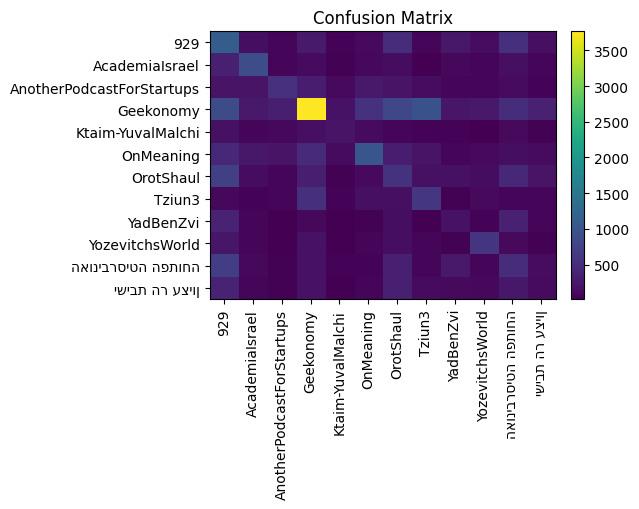

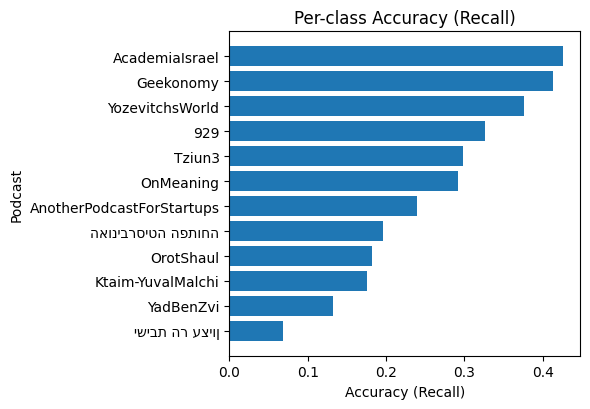

In [73]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

labels = sorted(np.unique(yte))
cm = confusion_matrix(yte, yhat, labels=labels)
cm_df = pd.DataFrame(cm, index=[f"true_{l}" for l in labels], columns=[f"pred_{l}" for l in labels])
export_table(cm_df, "tab_confusion_raw")

# heatmap
fig, ax = plt.subplots(figsize=(6.5, 5.2))
im = ax.imshow(cm, aspect="auto")
ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels, rotation=90)
ax.set_yticks(range(len(labels))); ax.set_yticklabels(labels)
ax.set_title("Confusion Matrix"); fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
savefig(fig, "fig_confusion")

# classification report
report_df = pd.DataFrame.from_dict(classification_report(yte, yhat, output_dict=True)).T
export_table(report_df.reset_index().rename(columns={"index":"class"}), "tab_clf_report", index=False)

# per-class accuracy (== recall in multi-class)
perclass = report_df.loc[[l for l in report_df.index if l in labels], ["precision","recall","f1-score","support"]].copy()
perclass.sort_values("recall", ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(6, 4.2))
ax.barh(perclass.index[::-1], perclass["recall"][::-1])
ax.set_xlabel("Accuracy (Recall)"); ax.set_ylabel("Podcast"); ax.set_title("Per-class Accuracy (Recall)")
savefig(fig, "fig_perclass_accuracy")

export_table(perclass.reset_index().rename(columns={"index":"podcast"}), "tab_perclass_accuracy", index=False)

# global numbers for macros
acc = report_df.loc["accuracy","precision"] if "accuracy" in report_df.index else (yhat==yte).mean()
macro_f1 = report_df.loc["macro avg","f1-score"]
write_tex_macros("numbers.tex", acc=acc, macroFone=macro_f1)

saved: figs\fig_rf_importances.pdf figs\fig_rf_importances.png
saved: tables\tab_feature_importances.csv tables\tab_feature_importances.tex


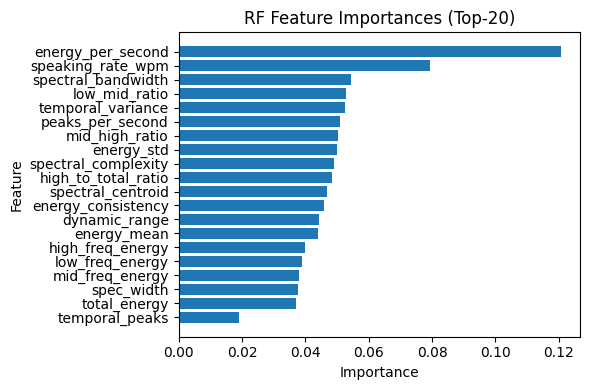

In [72]:
import matplotlib.pyplot as plt
import pandas as pd
imp = pd.DataFrame({
    "feature": production_features,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

# plot
fig, ax = plt.subplots(figsize=(6, 4))
topn = 20
ax.barh(imp.head(topn)["feature"][::-1], imp.head(topn)["importance"][::-1])
ax.set_xlabel("Importance"); ax.set_ylabel("Feature"); ax.set_title("RF Feature Importances (Top-20)")
savefig(fig, "fig_rf_importances")

# raw export
export_table(imp, "tab_feature_importances", index=False)

### 1) Misclassification summary: top-3 “nearest neighbors” per true class

In [52]:
# Build a simple per-class misclassification summary (percentages)
labels = sorted(np.unique(y))
cm_raw = confusion_matrix(yte, yhat, labels=labels)
cm_df = pd.DataFrame(cm_raw, index=labels, columns=labels)

def top_k_confusions(cm, k=3):
    rows = []
    for i, lab in enumerate(cm.index):
        row = cm.iloc[i]
        total = row.sum()
        # exclude diagonal
        off = row.drop(lab)
        pct = (off / max(1, total)).sort_values(ascending=False).head(k)
        for pred_lab, val in pct.items():
            rows.append({"true": lab, "pred": pred_lab, "rate": round(float(val), 3)})
    return pd.DataFrame(rows).sort_values(["true","rate"], ascending=[True, False])

mis_top3 = top_k_confusions(cm_df, k=3)
mis_top3.head(30)

,true,pred,rate
0,929,האוניברסיטה הפתוחה,0.156
1,929,OrotShaul,0.141
2,929,Geekonomy,0.085
3,AcademiaIsrael,929,0.163
4,AcademiaIsrael,האוניברסיטה הפתוחה,0.079
5,AcademiaIsrael,OrotShaul,0.068
6,AnotherPodcastForStartups,Geekonomy,0.137
7,AnotherPodcastForStartups,OnMeaning,0.115
8,AnotherPodcastForStartups,AcademiaIsrael,0.093
9,Geekonomy,Tziun3,0.104


### 2) “Style distance” between podcasts and its link to confusions

In [53]:
# --- SAFE style distance (drop-in replacement) ---
# Use the class_profiles already computed above (or reload from CSV)
profiles = class_profiles.copy()

# 1) Keep only finite columns; drop columns with any NaNs
profiles = profiles.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='any')

# 2) Drop zero-variance columns (these cause std=0 → NaNs on z-score)
var = profiles.var(axis=0, ddof=0)
profiles = profiles.loc[:, var > 1e-12]

if profiles.shape[1] == 0:
    raise ValueError("All profile features are zero-variance; cannot compute style distance.")

# 3) Safe z-score (avoid 0 std); then fill any residual NaNs with 0
mean = profiles.mean()
std = profiles.std(ddof=0).replace(0, np.nan)
z = (profiles - mean) / std
z = z.fillna(0.0)

# 4) Cosine similarity with safe norms
Z = z.values
norms = np.linalg.norm(Z, axis=1, keepdims=True)
norms = np.where(norms == 0, 1e-9, norms)
sim = (Z @ Z.T) / (norms * norms.T)
sim = np.clip(sim, -1.0, 1.0)
np.fill_diagonal(sim, 1.0)

labels_style = z.index.tolist()
sim_df = pd.DataFrame(sim, index=labels_style, columns=labels_style)
dist_df = 1 - sim_df  # keep your original convention

# 5) Align with confusion matrix labels to avoid key errors / hidden NaNs
labels_conf = cm_df.index.tolist()
labels = sorted(set(labels_style) & set(labels_conf))

cm_prob = cm_df.loc[labels, labels].div(cm_df.loc[labels].sum(axis=1).replace(0,1), axis=0)

# 6) Build pairwise table
pairs = []
for a in labels:
    for b in labels:
        if a == b: 
            continue
        style_closeness = 1 - dist_df.loc[a, b]  # == sim_df.loc[a, b]
        confusion_ab = float(cm_prob.loc[a, b])  # P(pred=b | true=a)
        pairs.append({"true": a, "pred": b, "style_closeness": float(style_closeness),
                      "confusion_rate": confusion_ab})
pairs_df = pd.DataFrame(pairs)

# Spearman (now finite)
from scipy.stats import spearmanr
rho, p = spearmanr(pairs_df["style_closeness"], pairs_df["confusion_rate"])
print(f"Spearman(style_closeness, confusion_rate) = {rho:.3f}, p={p:.3e}")

Spearman(style_closeness, confusion_rate) = 0.467, p=1.647e-08


In [56]:
pairs_df

,true,pred,style_closeness,confusion_rate
0,929,AcademiaIsrael,0.141515,0.044139
1,929,AnotherPodcastForStartups,-0.627325,0.020754
2,929,Geekonomy,-0.344550,0.085063
3,929,Ktaim-YuvalMalchi,-0.383242,0.013739
4,929,OnMeaning,-0.512209,0.031862
5,929,OrotShaul,0.839463,0.141479
6,929,Tziun3,-0.374913,0.016954
7,929,YadBenZvi,0.608684,0.073663
8,929,YozevitchsWorld,-0.286697,0.039462
9,929,האוניברסיטה הפתוחה,0.737393,0.155802


### 3) Which features differ most across podcasts? (Kruskal + effect size)

In [55]:
sec1_feats = [
    "duration","word_count","speaking_rate_wpm",
    "rms_mean","rms_std","zcr_mean","f0_median","f0_std",
    "n_pauses","mean_pause_s","median_pause_s","p90_pause_s","p95_pause_s",
    "pause_rate_per_min","silence_ratio","silence_to_speech_ratio","pause_burstiness_cv"
]
sec1_feats = [f for f in sec1_feats if f in clf_df.columns]

def kw_effect(df, feature):
    groups = [g[feature].dropna().values for _, g in df.groupby("podcast_name")]
    if len(groups) < 2 or any(len(g)<20 for g in groups): return None
    H, p = kruskal(*groups)
    n = sum(len(g) for g in groups); k = len(groups)
    eps2 = (H - k + 1) / max(1, (n - k))  # epsilon-squared effect size
    return H, p, eps2

rows = []
for f in sec1_feats:
    res = kw_effect(clf_df, f)
    if res:
        H,p,eps2 = res
        rows.append({"feature": f, "H": H, "p": p, "epsilon_sq": eps2})
print(rows)
kw_sec1 = pd.DataFrame(rows).sort_values("epsilon_sq", ascending=False)
kw_sec1.head(12)

[{'feature': 'duration', 'H': 3804.151852197892, 'p': 0.0, 'epsilon_sq': 0.02226459262766787}, {'feature': 'word_count', 'H': 10327.491659432875, 'p': 0.0, 'epsilon_sq': 0.06055451853605966}, {'feature': 'speaking_rate_wpm', 'H': 19857.439649916756, 'p': 0.0, 'epsilon_sq': 0.11649227637932673}, {'feature': 'n_pauses', 'H': 9331.659775710734, 'p': 0.0, 'epsilon_sq': 0.05471187184540138}, {'feature': 'pause_rate_per_min', 'H': 15097.067908242054, 'p': 0.0, 'epsilon_sq': 0.0885545695163863}, {'feature': 'silence_ratio', 'H': 14763.709929858784, 'p': 0.0, 'epsilon_sq': 0.08659777252659843}, {'feature': 'silence_to_speech_ratio', 'H': 14763.760665695969, 'p': 0.0, 'epsilon_sq': 0.08659807034377971}]


,feature,H,p,epsilon_sq
2,speaking_rate_wpm,19857.439650,0.0,0.116492
4,pause_rate_per_min,15097.067908,0.0,0.088555
6,silence_to_speech_ratio,14763.760666,0.0,0.086598
5,silence_ratio,14763.709930,0.0,0.086598
1,word_count,10327.491659,0.0,0.060555
3,n_pauses,9331.659776,0.0,0.054712
0,duration,3804.151852,0.0,0.022265


### 4) “Class signatures”: which features define each podcast?

In [57]:
def class_signature_table(df, features, top_n=5):
    out = []
    for lab, g in df.groupby("podcast_name"):
        others = df[df["podcast_name"]!=lab]
        for f in features:
            m1, m2 = g[f].mean(), others[f].mean()
            s1, s2 = g[f].std(ddof=1), others[f].std(ddof=1)
            n1, n2 = len(g), len(others)
            # pooled std (Hedges g denominator)
            sp = np.sqrt(((n1-1)*s1*s1 + (n2-1)*s2*s2) / max(1, (n1+n2-2)))
            gval = 0.0 if sp==0 or np.isnan(sp) else (m1 - m2) / sp
            out.append({"podcast_name": lab, "feature": f, "std_diff": gval})
    sig = pd.DataFrame(out)
    return sig.sort_values(["podcast_name","std_diff"], ascending=[True, False]).groupby("podcast_name").head(top_n)

sig_top = class_signature_table(clf_df, X_cols, top_n=6)
sig_top

,podcast_name,feature,std_diff
21,929,dynamic_range,0.161192
11,929,low_mid_ratio,0.089171
12,929,mid_high_ratio,0.045480
17,929,peaks_per_second,0.042168
14,929,spec_density,0.009767
13,929,spec_width,0.007306
43,AcademiaIsrael,dynamic_range,0.442985
24,AcademiaIsrael,energy_std,0.269227
33,AcademiaIsrael,low_mid_ratio,0.133974
32,AcademiaIsrael,high_freq_energy,0.111655


## 2) Pause Analysis — Thorough

In [66]:
pause_metrics = vad_df.columns

pm = analysis_50k.dropna(subset=["podcast_name"]).copy()
def kw_with_effect(metric):
    groups = [g[metric].dropna().values for _, g in pm.groupby("podcast_name")]
    ns = [len(g) for g in groups]
    if any(n<20 for n in ns) or len(groups)<2:
        return None
    H, p = kruskal(*groups)
    n = sum(ns); k = len(groups)
    eps2 = (H - k + 1) / (n - k)
    return H, p, eps2

kw_rows = []
for m in pause_metrics:
    res = kw_with_effect(m)
    if res is None: continue
    H, p, eps2 = res
    kw_rows.append({"metric": m, "H": H, "p": p, "epsilon_sq": eps2})
kw_tbl = pd.DataFrame(kw_rows).sort_values("epsilon_sq", ascending=False)
print("Kruskal–Wallis (per metric) with effect size ε²:"); display(kw_tbl)

# Dunn post-hoc for strongest metric
if not kw_tbl.empty:
    top_metric = kw_tbl.iloc[0]["metric"]
    print(f"\nDunn post-hoc (Holm) for top metric: {top_metric}")
    dunn = sp.posthoc_dunn(pm, val_col=top_metric, group_col="podcast_name", p_adjust="holm")
    display(dunn.iloc[:12,:12])
    dunn.to_csv(OUT_DIR/f"dunn_posthoc_{top_metric}.csv", encoding="utf-8-sig")

# Rank podcasts by pause rate
rank_tbl = pm.groupby("podcast_name")["pause_rate_per_min"].mean().sort_values(ascending=False)
print("\nPodcasts ranked by pause_rate_per_min (top 10):"); display(rank_tbl.head(10))
print("\nBottom 10:"); display(rank_tbl.tail(10))

# # Save
# kw_tbl.to_csv(OUT_DIR/"pause_kw_effect_sizes.csv", index=False, encoding="utf-8-sig")
# rel_tbl.to_csv(OUT_DIR/"pause_sentiment_global.csv", index=False, encoding="utf-8-sig")
# meta_pause_tbl.to_csv(OUT_DIR/"pause_sentiment_within_meta.csv", index=False, encoding="utf-8-sig")
# rank_tbl.to_csv(OUT_DIR/"pause_rate_ranking.csv", encoding="utf-8-sig")
# print("Saved pause-analysis tables to", OUT_DIR)

Kruskal–Wallis (per metric) with effect size ε²:


,metric,H,p,epsilon_sq
14,uuid,166358.234167,0.0,0.976405
13,sample_id,54572.707436,0.0,0.320275
11,speech_rate_wpm,19838.965643,0.0,0.116389
8,pause_rate_per_min,15097.067908,0.0,0.088555
12,silence_to_speech_ratio,14763.760666,0.0,0.086598
9,silence_ratio,14763.709930,0.0,0.086598
1,total_pause,10767.517387,0.0,0.063140
7,p95_pause,10320.400762,0.0,0.060516
6,p90_pause,10273.583305,0.0,0.060241
4,mean_pause,9722.442675,0.0,0.057006



Dunn post-hoc (Holm) for top metric: uuid


,929,AcademiaIsrael,AnotherPodcastForStartups,Geekonomy,Ktaim-YuvalMalchi,OnMeaning,OrotShaul,Tziun3,YadBenZvi,YozevitchsWorld,האוניברסיטה הפתוחה,ישיבת הר עציון
929,1.000000e+00,2.709105e-112,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
AcademiaIsrael,2.709105e-112,1.000000e+00,2.692586e-61,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
AnotherPodcastForStartups,0.000000e+00,2.692586e-61,1.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Geekonomy,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Ktaim-YuvalMalchi,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.000000e+00,1.305826e-55,5.505312e-306,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
OnMeaning,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.305826e-55,1.000000e+00,1.489534e-199,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
OrotShaul,0.000000e+00,0.000000e+00,0.000000e+00,0.0,5.505312e-306,1.489534e-199,1.000000e+00,1.234389e-90,7.242165e-203,0.000000e+00,0.000000e+00,0.000000e+00
Tziun3,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.234389e-90,1.000000e+00,1.434932e-29,6.256410e-105,0.000000e+00,0.000000e+00
YadBenZvi,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,7.242165e-203,1.434932e-29,1.000000e+00,5.776211e-21,6.193241e-130,9.932464e-295
YozevitchsWorld,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,6.256410e-105,5.776211e-21,1.000000e+00,1.259913e-46,1.579115e-168



Podcasts ranked by pause_rate_per_min (top 10):


podcast_name
929                          46.471143
OnMeaning                    34.155579
AcademiaIsrael               33.909401
YadBenZvi                    31.586518
האוניברסיטה הפתוחה           30.622620
ישיבת הר עציון               25.856285
AnotherPodcastForStartups    24.666018
Ktaim-YuvalMalchi            24.097829
YozevitchsWorld              22.154751
Geekonomy                    19.671750
Name: pause_rate_per_min, dtype: float64


Bottom 10:


podcast_name
AcademiaIsrael               33.909401
YadBenZvi                    31.586518
האוניברסיטה הפתוחה           30.622620
ישיבת הר עציון               25.856285
AnotherPodcastForStartups    24.666018
Ktaim-YuvalMalchi            24.097829
YozevitchsWorld              22.154751
Geekonomy                    19.671750
OrotShaul                    19.325247
Tziun3                       15.609678
Name: pause_rate_per_min, dtype: float64

### תא 1 — גזירת מדדים חדשים של עצירות/ריצות דיבור

In [67]:
# ==== New pause/run metrics derived from existing columns in df ====
work = analysis_50k.copy()

# זמנים בסיסיים
work["speech_time_s"] = (work["duration"] - work["total_pause"]).clip(lower=1e-6)

# 1) קצב היגוי אמיתי (מוציא את ההפסקות) לעומת speaking_rate_wpm
work["articulation_rate_wpm"] = (work["word_count"] / (work["speech_time_s"]/60.0)).replace([np.inf, -np.inf], np.nan)

# 2) מבנה "ריצות דיבור": נשתמש בקירוב (#קטעי דיבור = #עצירות+1)
work["n_runs"] = (work["n_pauses"] + 1).clip(lower=1)
work["mean_run_s"] = work["speech_time_s"] / work["n_runs"]
work["run_rate_per_min"] = work["n_runs"] / (work["duration"]/60.0)

# 3) זנב־ארוך של העצירות: יחס p95/median (גבוה ⇒ הרבה עצירות ארוכות יחסית)
work["pause_tail_index"] = np.where(work["median_pause"]>0,
                                    work["p95_pause"] / work["median_pause"], 0.0)

# 4) איזון דיבור־הפסקות: יחס ממוצע ריצה לממוצע עצירה
work["run_to_pause_balance"] = np.where(work["mean_pause"]>0,
                                        work["mean_run_s"] / work["mean_pause"], np.nan)

# 5) מדד פירוק/קיטוע: כמה ההפסקות "שוברות" את הדיבור
work["fragmentation_index"] = work["pause_rate_per_min"] * work["silence_ratio"]

new_cols = [
    "articulation_rate_wpm","mean_run_s","run_rate_per_min",
    "pause_tail_index","run_to_pause_balance","fragmentation_index"
]
work[new_cols].describe().round(3)

,articulation_rate_wpm,mean_run_s,run_rate_per_min,pause_tail_index,run_to_pause_balance,fragmentation_index
count,170371.000,170371.000,170371.000,170379.000,113430.000,170371.000
mean,156.359,2.318,42.602,1.397,44.433,1.510
std,59.193,2.295,29.135,1.978,62.242,3.063
min,0.000,0.120,2.069,0.000,0.985,0.000
25%,125.232,1.007,20.881,0.000,12.631,0.000
50%,153.728,1.704,34.453,1.000,24.372,0.260
75%,184.292,2.856,57.136,1.643,50.500,1.590
max,8953.368,28.996,500.000,68.500,1357.375,70.657


### תא 2 — נרמול (רזידואלים) להסרת השפעת אורך/מילים/קצב

In [68]:
# ==== Residualize pause/run metrics on duration, word_count, speaking_rate_wpm ====
base_controls = ["duration","word_count","speaking_rate_wpm"]
targets = [
    "pause_rate_per_min","silence_ratio","pause_burstiness_cv",
    "articulation_rate_wpm","mean_run_s","run_rate_per_min",
    "pause_tail_index","run_to_pause_balance","fragmentation_index"
]
targets = [t for t in targets if t in work.columns]

def residualize(df, y_col, x_cols):
    sub = df[x_cols + [y_col]].dropna().copy()
    X = np.column_stack([np.ones(len(sub))] + [sub[c].values for c in x_cols])
    y = sub[y_col].values
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    y_hat = X @ beta
    resid = y - y_hat
    # סטנדרטיזציה
    resid_std = (resid - resid.mean()) / (resid.std(ddof=1) + 1e-9)
    out = pd.Series(index=sub.index, data=resid_std, name=f"{y_col}_resid")
    return out

for t in targets:
    work[f"{t}_resid"] = residualize(work, t, base_controls)

resid_cols = [c for c in work.columns if c.endswith("_resid")]
work_resid = work.dropna(subset=["podcast_name"] + resid_cols).copy()
work_resid[resid_cols].head(3)

,pause_rate_per_min_resid,silence_ratio_resid,articulation_rate_wpm_resid,mean_run_s_resid,run_rate_per_min_resid,pause_tail_index_resid,run_to_pause_balance_resid,fragmentation_index_resid
0,0.116482,0.166678,0.196077,-0.484770,-0.060995,0.305069,-0.424170,-0.141930
1,0.034019,0.083077,-0.062361,-0.347608,-0.125953,0.248609,-0.350238,-0.101464
2,3.204758,0.684538,0.984167,-0.745027,3.480046,0.928285,-0.412755,1.220741


### תא 3 — השוואות בין פודקאסטים על המדדים המנורמלים + פוסט־הוק

In [69]:
from scipy.stats import kruskal

def kw_eps2(df, metric):
    groups = [g[metric].dropna().values for _, g in df.groupby("podcast_name")]
    ns = [len(g) for g in groups]
    if len(groups)<2 or any(n<20 for n in ns): return None
    H, p = kruskal(*groups)
    n = sum(ns); k = len(groups)
    eps2 = (H - k + 1) / max(1, n - k)
    return H, p, eps2

rows = []
for m in resid_cols:
    res = kw_eps2(work_resid, m)
    if res:
        H,p,eps2 = res
        rows.append({"metric": m, "H": H, "p": p, "epsilon_sq": eps2})
kw_resid = pd.DataFrame(rows).sort_values("epsilon_sq", ascending=False)
print("Kruskal–Wallis on residualized metrics (style-only):")
display(kw_resid.head(12))

# Post-hoc Dunn על המדד החזק ביותר
import scikit_posthocs as sp
if not kw_resid.empty:
    topm = kw_resid.iloc[0]["metric"]
    print(f"\nDunn post-hoc (Holm) for: {topm}")
    dunn = sp.posthoc_dunn(work_resid, val_col=topm, group_col="podcast_name", p_adjust="holm")
    display(dunn.iloc[:12,:12])

Kruskal–Wallis on residualized metrics (style-only):


,metric,H,p,epsilon_sq
2,articulation_rate_wpm_resid,11763.521905,0.0,0.103621
1,silence_ratio_resid,11161.695934,0.0,0.098315
7,fragmentation_index_resid,8322.093360,0.0,0.073278
0,pause_rate_per_min_resid,8084.664619,0.0,0.071185
4,run_rate_per_min_resid,7848.833591,0.0,0.069106
6,run_to_pause_balance_resid,6862.359526,0.0,0.060408
5,pause_tail_index_resid,4681.542964,0.0,0.041180
3,mean_run_s_resid,3172.497640,0.0,0.027875



Dunn post-hoc (Holm) for: articulation_rate_wpm_resid


,929,AcademiaIsrael,AnotherPodcastForStartups,Geekonomy,Ktaim-YuvalMalchi,OnMeaning,OrotShaul,Tziun3,YadBenZvi,YozevitchsWorld,האוניברסיטה הפתוחה,ישיבת הר עציון
929,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.625238e-149,0.000000e+00,7.564856e-304,0.000000e+00,9.709512e-88,0.000000e+00,5.893432e-144,5.322658e-60
AcademiaIsrael,0.000000e+00,1.000000e+00,1.244521e-84,2.243131e-173,2.397425e-04,2.204015e-10,2.083983e-02,6.404581e-84,2.833279e-43,1.814642e-48,1.882231e-47,9.027238e-80
AnotherPodcastForStartups,0.000000e+00,1.244521e-84,1.000000e+00,4.479034e-03,2.523728e-84,7.389074e-52,1.716103e-108,4.615720e-01,7.663459e-214,4.705751e-02,1.151821e-260,1.244227e-302
Geekonomy,0.000000e+00,2.243131e-173,4.479034e-03,1.000000e+00,6.051654e-134,1.241565e-137,5.739767e-212,4.615720e-01,0.000000e+00,3.368566e-08,0.000000e+00,0.000000e+00
Ktaim-YuvalMalchi,5.625238e-149,2.397425e-04,2.523728e-84,6.051654e-134,1.000000e+00,2.424192e-20,2.357276e-01,9.339761e-86,6.346175e-13,1.698683e-56,1.503125e-11,2.912278e-28
OnMeaning,0.000000e+00,2.204015e-10,7.389074e-52,1.241565e-137,2.424192e-20,1.000000e+00,9.117450e-22,1.243431e-52,4.679012e-97,3.257460e-24,4.995456e-120,1.709957e-161
OrotShaul,7.564856e-304,2.083983e-02,1.716103e-108,5.739767e-212,2.357276e-01,9.117450e-22,1.000000e+00,4.682632e-106,3.740419e-28,2.950075e-65,3.260787e-29,4.664219e-57
Tziun3,0.000000e+00,6.404581e-84,4.615720e-01,4.615720e-01,9.339761e-86,1.243431e-52,4.682632e-106,1.000000e+00,1.906095e-205,2.015796e-03,2.915542e-242,1.554305e-284
YadBenZvi,9.709512e-88,2.833279e-43,7.663459e-214,0.000000e+00,6.346175e-13,4.679012e-97,3.740419e-28,1.906095e-205,1.000000e+00,1.535744e-148,4.615720e-01,9.451926e-04
YozevitchsWorld,0.000000e+00,1.814642e-48,4.705751e-02,3.368566e-08,1.698683e-56,3.257460e-24,2.950075e-65,2.015796e-03,1.535744e-148,1.000000e+00,5.360173e-170,1.523389e-210


### תא 4 — קלאסטרינג של סגנונות פרודקשן והטמעת הפודקאסטים בתוכם

In [70]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# נבחר וקטור תכונות מנורמלות שמאפיין סגנון פרודקשן
style_cols = [
    "pause_rate_per_min_resid","silence_ratio_resid","pause_burstiness_cv_resid",
    "articulation_rate_wpm_resid","mean_run_s_resid","run_rate_per_min_resid",
    "pause_tail_index_resid","run_to_pause_balance_resid","fragmentation_index_resid"
]
style_cols = [c for c in style_cols if c in work_resid.columns]

X = work_resid[style_cols].fillna(0.0).values
sc = StandardScaler(with_mean=False)  # כבר סטנדרטי (רזידואלים), שומרים קנה מידה
Xn = sc.fit_transform(X)

best = None
for k in [3,4,5]:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    lab = km.fit_predict(Xn)
    sil = silhouette_score(Xn, lab)
    if (best is None) or (sil > best[0]): best = (sil, k, km, lab)
sil, K, km, labels_k = best
work_resid["style_cluster"] = labels_k
print(f"Chosen K={K} with silhouette={sil:.3f}")

# תיאור אשכולות
cent = pd.DataFrame(km.cluster_centers_, columns=style_cols).round(3)
print("\nCluster centroids (style z-residual space):")
display(cent)

# התפלגות פודקאסטים בכל אשכול
dist = (work_resid.groupby(["podcast_name","style_cluster"]).size()
        .unstack(fill_value=0))
dist_pct = (dist.div(dist.sum(axis=1).replace(0,1), axis=0).round(3)*100)
print("\nDistribution % of each podcast across style clusters:")
display(dist_pct)

# נשמור טבלאות
dist_pct.to_csv(OUT_DIR/"pause_style_cluster_distribution.csv", encoding="utf-8-sig")
cent.to_csv(OUT_DIR/"pause_style_cluster_centroids.csv", encoding="utf-8-sig")
print("Saved cluster tables to ./outputs")

Chosen K=5 with silhouette=0.325

Cluster centroids (style z-residual space):


,pause_rate_per_min_resid,silence_ratio_resid,articulation_rate_wpm_resid,mean_run_s_resid,run_rate_per_min_resid,pause_tail_index_resid,run_to_pause_balance_resid,fragmentation_index_resid
0,1.055,0.688,0.651,-1.495,1.031,0.395,-0.439,0.387
1,-0.073,-0.181,-0.174,-0.634,-0.093,-0.009,0.035,-0.289
2,2.455,2.447,2.359,-1.732,2.382,0.928,-0.579,2.731
3,0.937,1.109,1.083,-1.805,0.841,4.159,-0.576,0.704
4,-0.557,-0.673,-0.655,0.573,-0.631,-0.345,2.470,-0.434



Distribution % of each podcast across style clusters:


style_cluster,0,1,2,3,4
podcast_name,,,,,
929,41.4,31.7,20.7,4.3,1.9
AcademiaIsrael,34.5,51.6,8.2,1.2,4.5
AnotherPodcastForStartups,29.0,55.6,3.7,2.4,9.3
Geekonomy,25.8,55.5,3.4,2.7,12.7
Ktaim-YuvalMalchi,34.8,47.0,8.4,3.8,6.0
OnMeaning,36.8,48.5,6.7,2.3,5.7
OrotShaul,30.4,46.4,10.0,3.8,9.4
Tziun3,24.3,56.5,3.5,2.8,12.8
YadBenZvi,32.9,43.2,14.7,3.7,5.5


Saved cluster tables to ./outputs


saved: figs\fig_pause_kw.pdf figs\fig_pause_kw.png
saved: tables\tab_kw.csv tables\tab_kw.tex


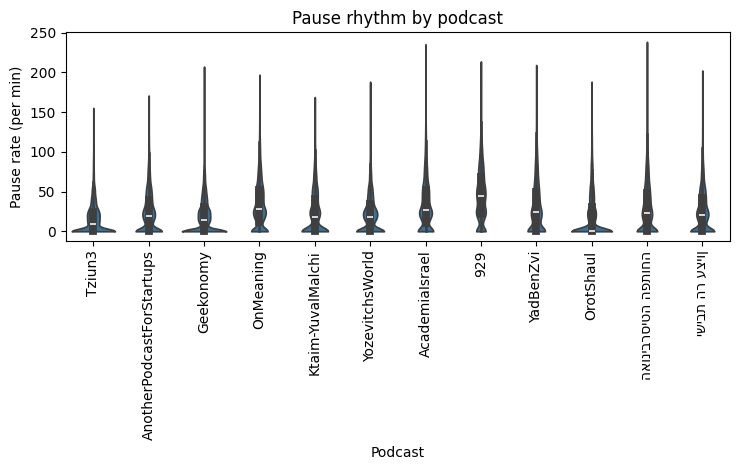

In [74]:
# Example: violin/box of pause_rate_per_min residualized by duration if you did that
import matplotlib.pyplot as plt
import seaborn as sns

# suppose df has columns: podcast_name, pause_rate_per_min_resid
dfp = work.dropna(subset=["podcast_name","pause_rate_per_min"])
fig, ax = plt.subplots(figsize=(7.5, 4.8))
sns.violinplot(data=dfp, x="podcast_name", y="pause_rate_per_min", inner="box", cut=0, ax=ax)
ax.set_xlabel("Podcast"); ax.set_ylabel("Pause rate (per min)"); ax.set_title("Pause rhythm by podcast")
ax.tick_params(axis='x', rotation=90)
savefig(fig, "fig_pause_kw")

# KW results table you already compute -> export
# Example structure:
kw = pd.DataFrame({
    "Metric": ["pause_rate_per_min","silence_ratio"],
    "H": [1144.61, np.nan], "p":[4.65e-244, np.nan], "epsilon2":[np.nan, np.nan]
})
export_table(kw, "tab_kw", index=False)

In [71]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

FIG_DIR = Path("figs");  FIG_DIR.mkdir(exist_ok=True, parents=True)
TAB_DIR = Path("tables"); TAB_DIR.mkdir(exist_ok=True, parents=True)

def savefig(fig, name, tight=True, dpi=300):
    path_pdf = FIG_DIR / f"{name}.pdf"
    path_png = FIG_DIR / f"{name}.png"
    if tight:
        fig.tight_layout()
    fig.savefig(path_pdf, bbox_inches="tight")
    fig.savefig(path_png, dpi=dpi, bbox_inches="tight")
    print("saved:", path_pdf, path_png)

def export_table(df, name, index=False, floatfmt="%.3f"):
    # CSV for your sanity, plus LaTeX for direct \input
    csv_path = TAB_DIR / f"{name}.csv"
    tex_path = TAB_DIR / f"{name}.tex"
    df.to_csv(csv_path, index=index)
    safe = df.copy()
    safe.columns = [c.replace("_", r"\_") for c in safe.columns]
    tex = safe.to_latex(index=index, float_format=floatfmt.__mod__ if "%." in floatfmt else None)
    tex_path.write_text(tex, encoding="utf-8")
    print("saved:", csv_path, tex_path)

def write_tex_macros(path, **kw):
    """write \newcommand macros for key scalars (e.g., accuracy)."""
    lines = []
    for k, v in kw.items():
        if isinstance(v, float):
            lines.append(rf"\newcommand{{\{k}}}{{{v:.3f}}}")
        else:
            lines.append(rf"\newcommand{{\{k}}}{{{v}}}")
    Path(path).write_text("\n".join(lines) + "\n", encoding="utf-8")
    print("saved:", path)

## 3) Spectograms

Sampling patches for codebook: 100%|█| 6000/6000 [00:14<00:00, 428.06it/


Encoding 100,000 spectrograms  →  histograms (64 dims)


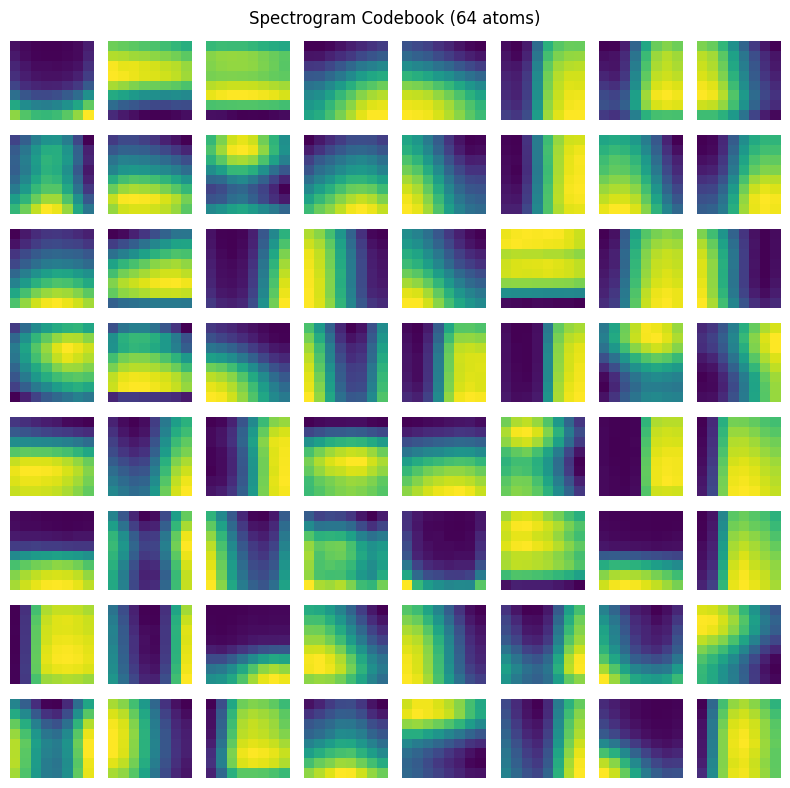

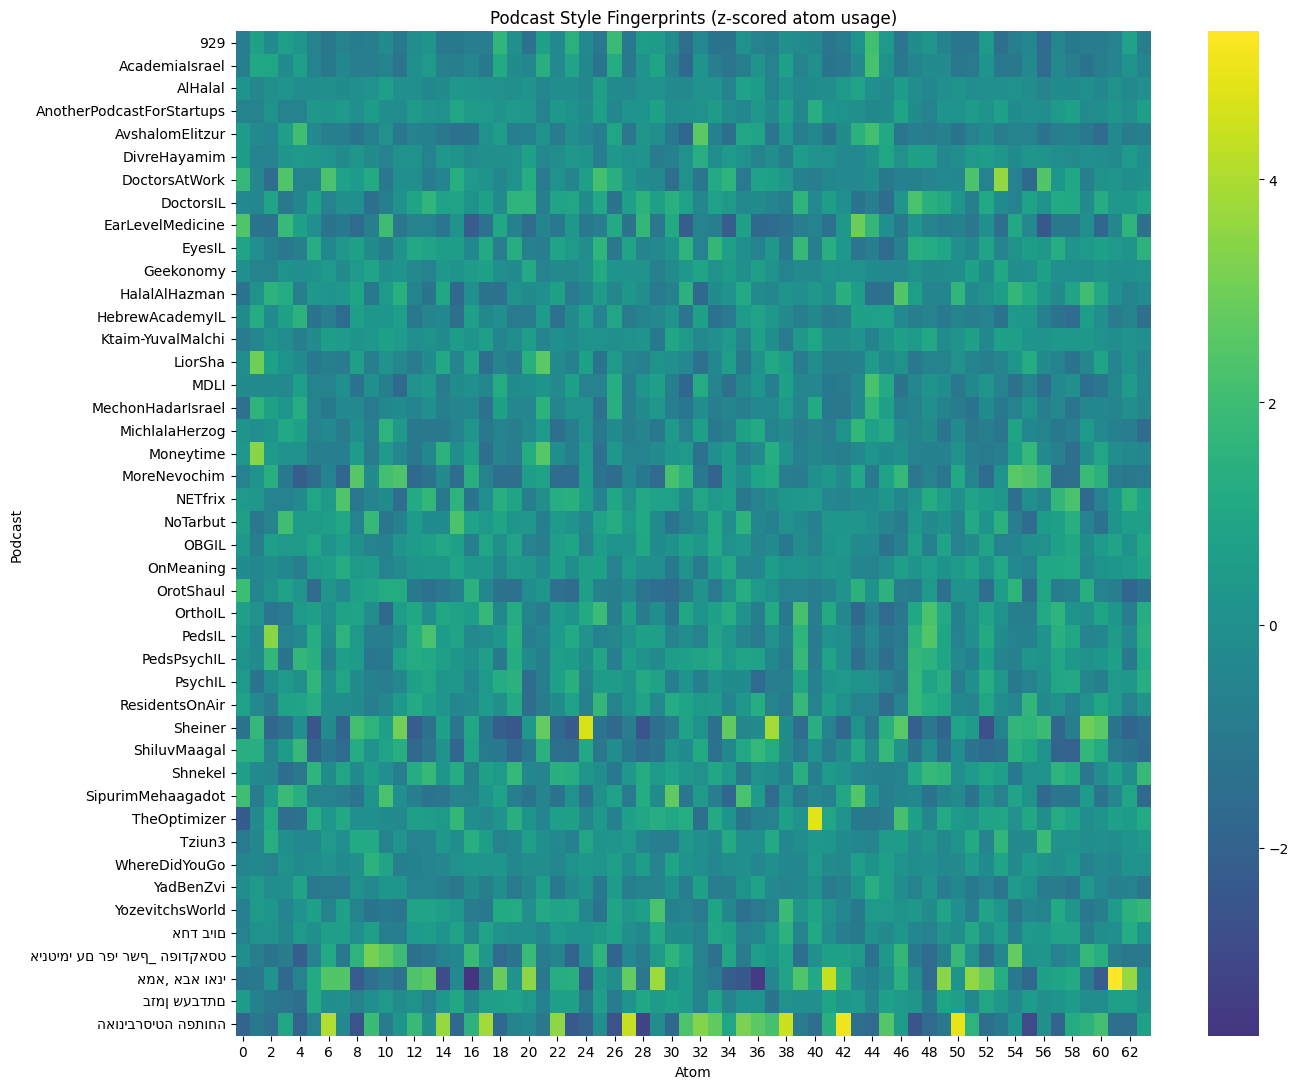

In [65]:
# ==== FAST 220K VERSION: Spectrogram Archetypes & Fingerprints ====
import os, numpy as np, pandas as pd
from pathlib import Path
from joblib import Parallel, delayed
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import normalize
from tqdm import tqdm

SPEC_DIR = Path("./test/spectrograms")
META_PKL = Path("./test/metadata_50k.pkl")   # for 220K, point this at your full metadata
assert META_PKL.exists(), "metadata pkl not found"
meta = pd.read_pickle(META_PKL)
meta['spec_path'] = meta['spec_filename'].apply(lambda f: str(SPEC_DIR / f))
valid = meta[meta['spec_path'].apply(os.path.exists)].copy()
valid.reset_index(drop=True, inplace=True)

# -------- CONFIG: tune these 4 knobs for speed vs. fidelity --------
K = 64               # codebook size
PATCH_MELS = 8       # patch height (mel bins)
PATCH_TIME = 8       # patch width (frames)
STEP = 8             # stride along mel/time (bigger = faster). Use 8–12 for 220K
CAP = 400            # max patches per clip (caps compute). 300–500 is plenty
DS_FACTOR = 2        # optional temporal downsample of spectrogram: 1(no DS), 2 or 3 = faster
RNG_SEED = 123
# -------------------------------------------------------------------

rng = np.random.default_rng(RNG_SEED)

# 1) Learn codebook on a *small sample* of spectrograms (fast, CPU-friendly)
def sample_patches(n_specs=6000, patches_per_spec=12):
    paths = valid['spec_path'].tolist()
    rng.shuffle(paths)
    picked = paths[:min(n_specs, len(paths))]
    bag = []
    for p in tqdm(picked, desc="Sampling patches for codebook", mininterval=1.0):
        S = np.load(p, mmap_mode='r')  # memmap for low RAM
        if DS_FACTOR > 1: S = S[:, ::DS_FACTOR]
        m, t = S.shape
        if m < PATCH_MELS or t < PATCH_TIME: 
            continue
        # build a coarse grid of start positions
        is_ = np.arange(0, m - PATCH_MELS + 1, STEP)
        js_ = np.arange(0, t - PATCH_TIME + 1, STEP)
        if len(is_) == 0 or len(js_) == 0: 
            continue
        ij = np.stack(np.meshgrid(is_, js_, indexing="ij"), axis=-1).reshape(-1, 2)
        if len(ij) == 0:
            continue
        # subsample fixed number per spec
        take = min(patches_per_spec, len(ij))
        sel = ij[rng.choice(len(ij), size=take, replace=False)]
        for i, j in sel:
            patch = S[i:i+PATCH_MELS, j:j+PATCH_TIME].astype(np.float32, copy=False)
            bag.append(patch.reshape(-1))
    if not bag:
        raise RuntimeError("No patches collected for codebook")
    return np.vstack(bag).astype(np.float32)

patches = sample_patches(n_specs=6000, patches_per_spec=12)
kmeans = MiniBatchKMeans(n_clusters=K, batch_size=8192, random_state=RNG_SEED, n_init="auto")
kmeans.fit(patches)

# 2) Fast per-clip encoding with stride + cap + (optional) temporal DS
def spec_to_hist_fast(S):
    if DS_FACTOR > 1: S = S[:, ::DS_FACTOR]
    m, t = S.shape
    if m < PATCH_MELS or t < PATCH_TIME:
        return np.zeros(K, dtype=np.float32)
    is_ = np.arange(0, m - PATCH_MELS + 1, STEP)
    js_ = np.arange(0, t - PATCH_TIME + 1, STEP)
    if len(is_) == 0 or len(js_) == 0:
        return np.zeros(K, dtype=np.float32)
    ij = np.stack(np.meshgrid(is_, js_, indexing="ij"), axis=-1).reshape(-1, 2)
    # cap number of patches so cost per clip is bounded
    take = min(CAP, len(ij))
    sel = ij if take == len(ij) else ij[rng.choice(len(ij), size=take, replace=False)]
    # small loop is fine (<= CAP); keeps memory tiny
    X = np.empty((len(sel), PATCH_MELS * PATCH_TIME), dtype=np.float32)
    for k, (i, j) in enumerate(sel):
        X[k] = S[i:i+PATCH_MELS, j:j+PATCH_TIME].reshape(-1)
    labels = kmeans.predict(X)  # vectorized over the batch
    h = np.bincount(labels, minlength=K).astype(np.float32)
    s = h.sum()
    return h / (s + 1e-9)

# 3) Encode ALL spectrograms in parallel (threads work well here)
N = len(valid)
print(f"Encoding {N:,} spectrograms  →  histograms ({K} dims)")

def encode_one(idx, fp):
    try:
        S = np.load(fp, mmap_mode='r')
        return idx, spec_to_hist_fast(S)
    except Exception:
        return idx, np.zeros(K, dtype=np.float32)

results = Parallel(n_jobs=-1, prefer="threads", batch_size=64)(
    delayed(encode_one)(i, fp) for i, fp in enumerate(valid['spec_path'].tolist())
)

# 4) Assemble H efficiently (float32) — fits in RAM (~56 MB for 220K×64)
H = np.empty((N, K), dtype=np.float32)
for i, h in results:
    H[i] = h
H = normalize(H, norm="l1")  # safety

# 5) Aggregate per-podcast fingerprints (same as before)
valid['podcast'] = valid['uuid'].str.split('/').str[0]
fingerprints = pd.DataFrame(H).groupby(valid['podcast']).mean()

# 6) (Optional) Save artifacts for later reuse
np.save("histograms_codebook64.npy", H)               # clip-level histograms
pd.to_pickle(kmeans, "codebook_kmeans_64.pkl")        # learned codebook
fingerprints.to_parquet("podcast_fingerprints.parquet")

# 7) (Optional) Visuals — identical to your originals
import matplotlib.pyplot as plt
atoms = kmeans.cluster_centers_.reshape(K, PATCH_MELS, PATCH_TIME)
fig, axes = plt.subplots(int(np.sqrt(K)), int(np.sqrt(K)), figsize=(8, 8))
for idx, ax in enumerate(axes.ravel()):
    ax.imshow(atoms[idx], aspect='auto', origin='lower')
    ax.axis('off')
plt.suptitle(f"Spectrogram Codebook ({K} atoms)"); plt.tight_layout(); plt.show()

import seaborn as sns
Z = (fingerprints - fingerprints.mean(0)) / (fingerprints.std(0) + 1e-9)
plt.figure(figsize=(14, max(6, 0.25*len(Z))))
sns.heatmap(Z, cmap="viridis", center=0)
plt.title("Podcast Style Fingerprints (z-scored atom usage)")
plt.xlabel("Atom"); plt.ylabel("Podcast"); plt.tight_layout(); plt.show()

In [80]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

FIG_DIR = Path("figs");  FIG_DIR.mkdir(parents=True, exist_ok=True)
TAB_DIR = Path("tables"); TAB_DIR.mkdir(parents=True, exist_ok=True)

def savefig_both(fig, name, tight=True, dpi=300):
    if tight: fig.tight_layout()
    fig.savefig(FIG_DIR / f"{name}.png", dpi=dpi, bbox_inches="tight")
    fig.savefig(FIG_DIR / f"{name}.pdf", bbox_inches="tight")
    print("saved:", FIG_DIR / f"{name}.png", "|", FIG_DIR / f"{name}.pdf")

def export_table_tex(df, name, index=False, colfmt=None, na_rep="--"):
    if colfmt is None:
        colfmt = ("l" if index or "podcast" in df.columns[:1] else "r") + "r"*(df.shape[1]-1)
    tex = df.to_latex(index=index, escape=True, na_rep=na_rep,
                      column_format=colfmt, float_format=lambda x: f"{x:.3f}")
    (TAB_DIR / f"{name}.tex").write_text(tex, encoding="utf-8")
    df.to_csv(TAB_DIR / f"{name}.csv", index=index)
    print("saved:", TAB_DIR / f"{name}.tex")

saved: figs\fig_atoms_grid.pdf figs\fig_atoms_grid.png


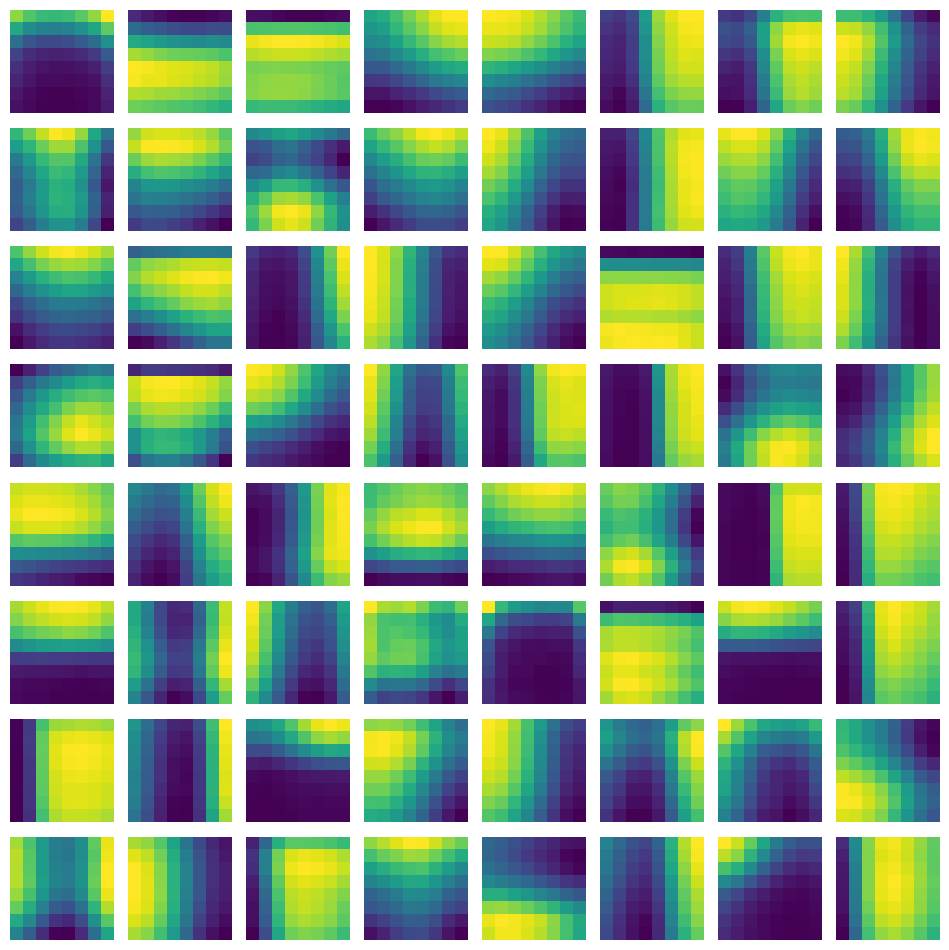

In [75]:
# assume kmeans.cluster_centers_.shape == (K, 64) for 8x8 patches
K = kmeans.cluster_centers_.shape[0]
atoms = kmeans.cluster_centers_.reshape(K, 8, 8)

ncols = 8
nrows = int(np.ceil(K/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(1.2*ncols, 1.2*nrows))
axes = axes.ravel()
for i in range(nrows*ncols):
    ax = axes[i]
    ax.axis("off")
    if i < K:
        ax.imshow(atoms[i], aspect="equal")
savefig(fig, "fig_atoms_grid")

saved: figs\fig_atoms_grid.png | figs\fig_atoms_grid.pdf
saved: figs\fig_fingerprints.png | figs\fig_fingerprints.pdf
saved: tables\tab_fingerprints_topN.tex


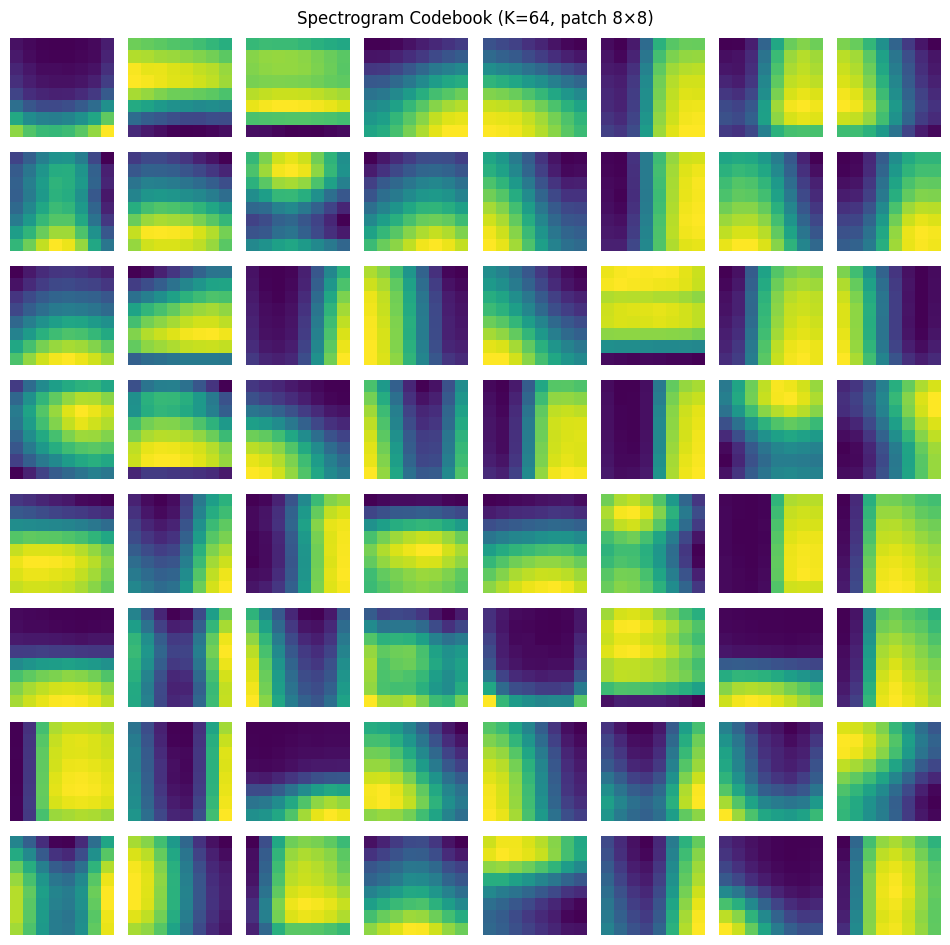

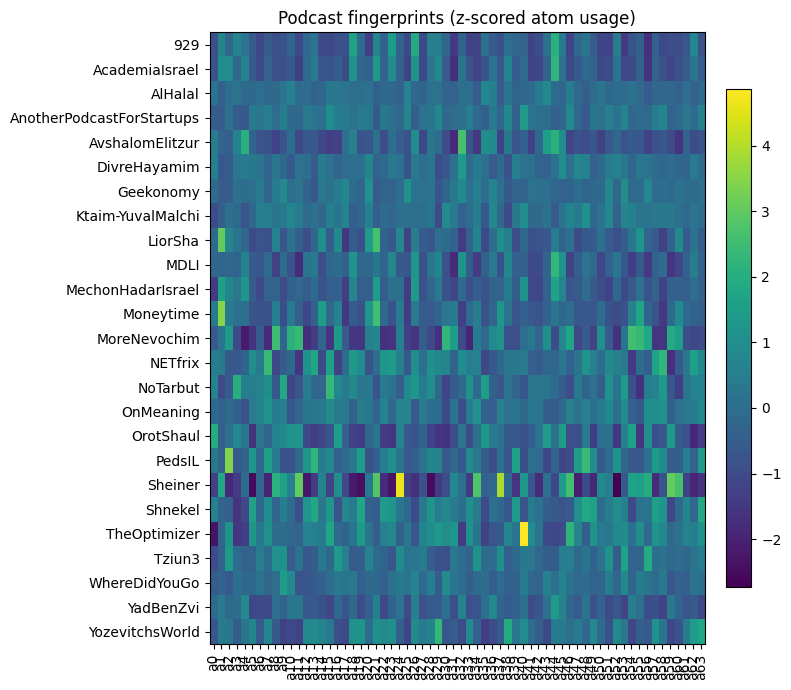

In [81]:
# ---------- 7a) Atoms grid ----------
# kmeans.cluster_centers_.shape == (K, PATCH_MELS*PATCH_TIME)
atoms = kmeans.cluster_centers_.reshape(K, PATCH_MELS, PATCH_TIME)

# Compute a nice grid even if K isn't a perfect square
ncols = int(np.ceil(np.sqrt(K)))
nrows = int(np.ceil(K / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(1.2*ncols, 1.2*nrows))
axes = np.atleast_1d(axes).ravel()
for i, ax in enumerate(axes):
    ax.axis("off")
    if i < K:
        ax.imshow(atoms[i], aspect="auto", origin="lower")
fig.suptitle(f"Spectrogram Codebook (K={K}, patch {PATCH_MELS}×{PATCH_TIME})", y=0.98)
savefig_both(fig, "fig_atoms_grid")

# ---------- 7b) Podcast fingerprints heatmap ----------
# Your code computed:
#   valid['podcast'] = valid['uuid'].str.split('/').str[0]
#   fingerprints = pd.DataFrame(H).groupby(valid['podcast']).mean()
# Robust: if you already have 'podcast_name', prefer it
podcol = "podcast_name" if "podcast_name" in valid.columns else "podcast"
if podcol not in valid.columns:
    valid[podcol] = valid["uuid"].str.split("/").str[0]

# Z-score by column to highlight relative usage
from scipy.stats import zscore
F = fingerprints.copy()
F.index.name = podcol
Z = F.apply(lambda col: zscore(col, nan_policy="omit"), axis=0).replace([np.inf, -np.inf], 0).fillna(0)

# Keep Top-N podcasts by clip count so the figure is readable
TOP_N = 25
counts_source = (valid[podcol].value_counts() if podcol in valid.columns else pd.Series(dtype=int))
keep = counts_source.head(TOP_N).index if len(counts_source) else Z.index
Ztop = Z.loc[Z.index.intersection(keep)]

fig_h = max(4, 0.28 * len(Ztop))
fig, ax = plt.subplots(figsize=(8, fig_h))
im = ax.imshow(Ztop.values, aspect="auto")
ax.set_yticks(range(len(Ztop.index))); ax.set_yticklabels(Ztop.index)
ax.set_xticks(range(Ztop.shape[1])); ax.set_xticklabels([f"a{i}" for i in range(Ztop.shape[1])], rotation=90)
ax.set_title("Podcast fingerprints (z-scored atom usage)")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
savefig_both(fig, "fig_fingerprints")

# Optional: export matrix as a LaTeX table too (so we can \input it if needed)
export_table_tex(Ztop.reset_index().rename(columns={Ztop.index.name: "podcast"}),
                 "tab_fingerprints_topN", index=False)